## **Predicting Credit Card Default**

Thinkful Supervised ML Capstone

Mike McIntire (m.mcintire00@gmail.com)

### Notebook Version 2.0
####*Please see original version of notebook or README for background information and original work with the dataset.*



--------------------

This is an updated notebook for my supervised learning capstone. Updates include:
* oversampling data with SMOTE to account for class imbalance of target variable.
* using RandomizedSearchCV paired with GridSearchCV to narrow input values and reduce run time.
* Assessing Precision-recall, focusing on improving recall for people who defaults



## Load Data

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sample_data
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:,.2f}'.format

credit_df = pd.read_excel('https://github.com/mmcintire00/supervised-learning-capstone/blob/main/data/default%20of%20credit%20card%20clients.xls?raw=true')

In [147]:
credit_df.shape

(30001, 25)

In [148]:
credit_df.head(10)

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,6,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,7,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,8,100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
9,9,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0


First thing to do is to change the column header to the first row of data. This row has the names of the variables I will use for my analysis.

In [149]:
new_header = credit_df.iloc[0]
credit_df = credit_df[1:] #take all the data minus the first row
credit_df.columns = new_header # set the header row as the df header
credit_df = credit_df.drop(columns=['ID']) # dropping id because it is not needed for this analysis
credit_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


That seemed to work. Now I want to make all column names lower case for ease while writing code. This is my personal preference.

In [150]:
credit_df.columns = [x.lower() for x in credit_df.columns] # loop to make column names lowercase for ease

In [151]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   limit_bal                   30000 non-null  object
 1   sex                         30000 non-null  object
 2   education                   30000 non-null  object
 3   marriage                    30000 non-null  object
 4   age                         30000 non-null  object
 5   pay_0                       30000 non-null  object
 6   pay_2                       30000 non-null  object
 7   pay_3                       30000 non-null  object
 8   pay_4                       30000 non-null  object
 9   pay_5                       30000 non-null  object
 10  pay_6                       30000 non-null  object
 11  bill_amt1                   30000 non-null  object
 12  bill_amt2                   30000 non-null  object
 13  bill_amt3                   30000 non-null  ob

I want to rename 'pay_0' to 'pay_1'. From what I can see in the raw data this variable was mislabeled. Renaming to 'pay_1' will match the other payment and bill variables. Also, the target variable is really long, so I will also rename to 'default'.

In [152]:
credit_df = credit_df.rename(columns={'pay_0':'pay_1', 'default payment next month':'default'}) # rename variables

Great. Now I will check for null values.

In [153]:
credit_df.isnull().sum() # check for null values

limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_1        0
pay_2        0
pay_3        0
pay_4        0
pay_5        0
pay_6        0
bill_amt1    0
bill_amt2    0
bill_amt3    0
bill_amt4    0
bill_amt5    0
bill_amt6    0
pay_amt1     0
pay_amt2     0
pay_amt3     0
pay_amt4     0
pay_amt5     0
pay_amt6     0
default      0
dtype: int64

No null values, but a lot of the numerical data is misclassified as objects. Converting numerical values to ints.

In [154]:
cols_2_convert = credit_df[['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 
                                   'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 
                                   'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']].columns # list of column names
for x in cols_2_convert: # loop converting data type from object to string to integer
  credit_df[x] = credit_df[x].astype(int)
credit_df.info() # check data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   limit_bal  30000 non-null  int64 
 1   sex        30000 non-null  object
 2   education  30000 non-null  object
 3   marriage   30000 non-null  object
 4   age        30000 non-null  int64 
 5   pay_1      30000 non-null  object
 6   pay_2      30000 non-null  object
 7   pay_3      30000 non-null  object
 8   pay_4      30000 non-null  object
 9   pay_5      30000 non-null  object
 10  pay_6      30000 non-null  object
 11  bill_amt1  30000 non-null  int64 
 12  bill_amt2  30000 non-null  int64 
 13  bill_amt3  30000 non-null  int64 
 14  bill_amt4  30000 non-null  int64 
 15  bill_amt5  30000 non-null  int64 
 16  bill_amt6  30000 non-null  int64 
 17  pay_amt1   30000 non-null  int64 
 18  pay_amt2   30000 non-null  int64 
 19  pay_amt3   30000 non-null  int64 
 20  pay_amt4   30000 non-null  i

Numerical variables were successfully changed to integers. I'm going to break numerical and categorical data into two data frames for plotting purposes.

In [155]:
cat_vars = credit_df.drop(columns=['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 
                                   'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 
                                   'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default'])

num_vars = credit_df[['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 
                                   'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 
                                   'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']]

In [156]:
cat_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sex        30000 non-null  object
 1   education  30000 non-null  object
 2   marriage   30000 non-null  object
 3   pay_1      30000 non-null  object
 4   pay_2      30000 non-null  object
 5   pay_3      30000 non-null  object
 6   pay_4      30000 non-null  object
 7   pay_5      30000 non-null  object
 8   pay_6      30000 non-null  object
dtypes: object(9)
memory usage: 2.1+ MB


In [157]:
num_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   limit_bal  30000 non-null  int64
 1   age        30000 non-null  int64
 2   bill_amt1  30000 non-null  int64
 3   bill_amt2  30000 non-null  int64
 4   bill_amt3  30000 non-null  int64
 5   bill_amt4  30000 non-null  int64
 6   bill_amt5  30000 non-null  int64
 7   bill_amt6  30000 non-null  int64
 8   pay_amt1   30000 non-null  int64
 9   pay_amt2   30000 non-null  int64
 10  pay_amt3   30000 non-null  int64
 11  pay_amt4   30000 non-null  int64
 12  pay_amt5   30000 non-null  int64
 13  pay_amt6   30000 non-null  int64
dtypes: int64(14)
memory usage: 3.2 MB


In [158]:
cat_vars.describe()

,sex,education,marriage,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
count,30000,30000,30000,30000,30000,30000,30000,30000,30000
unique,2,7,4,11,11,11,11,10,10
top,2,2,2,0,0,0,0,0,0
freq,18112,14030,15964,14737,15730,15764,16455,16947,16286


The split worked. Now I can make a condensed histogram plot for numerical values using matplotlib.

## Initial Data Exploration

This will be a high level exploration of the variables in the dataset using matplotlib. I'll use these to help build more interesting and beautiful plots about the variables below.

First, let's take a look at a simple bar chart that explains the probability of default for this dataset.

Text(0, 0.5, 'Probability')

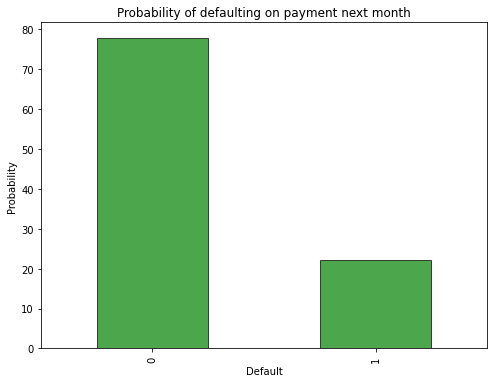

In [159]:
plt.figure(figsize=(8,6))
prob_of_default= (credit_df['default'].value_counts(normalize=True)*100)
prob_of_default.plot.bar(color='g', ec='black', alpha=0.7)
plt.title('Probability of defaulting on payment next month')
plt.xlabel('Default')
plt.ylabel('Probability')

Approximately 22% of individuals in this dataset have defaulted on a credit card payment. The target variable is imbalanced, which means I will need to evaluate model performance with precision, recall, and f-scores. Now  take a look at the distribution of the numerical variables.

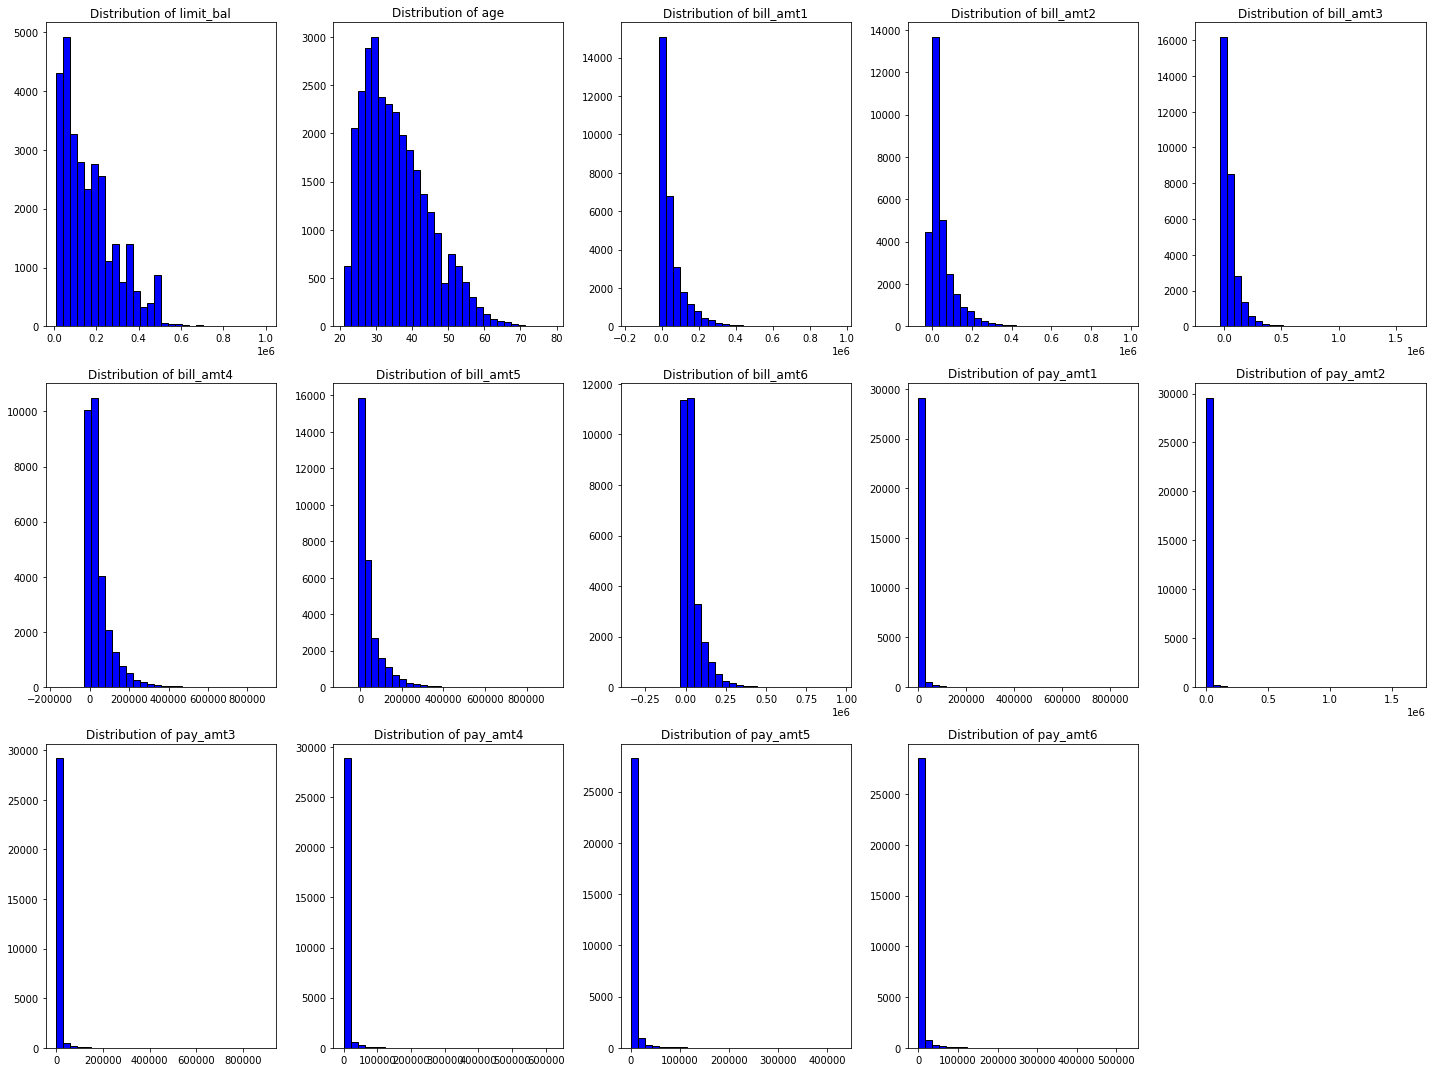

In [160]:
# numerical data histograms after cleaning data
plt.figure(figsize=(20, 15))

var_list = num_vars.columns.unique()

for index, column in enumerate(var_list):
  plt.subplot(3,5,index+1)
  plt.hist(num_vars[column], color='b', ec='black', bins=30)
  plt.title('Distribution of {}'.format(column))
  plt.bar

plt.tight_layout()
plt.show()

Woah! The data is highly skewed to the right, specifically the monthly bill and payment amounts. It also looks like the most common value is 0 , with the exception of a few monthly bills. This means that the majority of individuals in this study on most months either have a bill of 0 or a payment amount of 0. Below I will check to see how skewed the data is for 

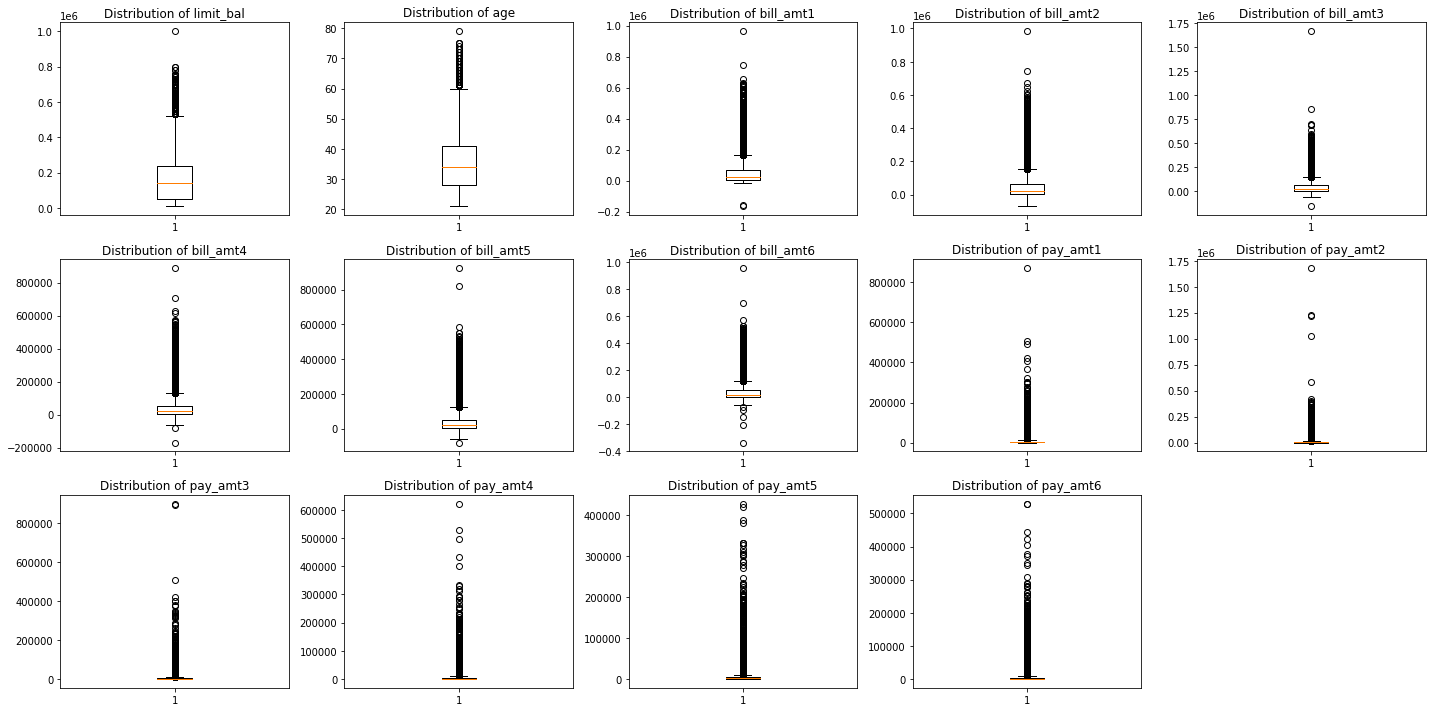

In [161]:
plt.figure(figsize=(20,10))

var_list = num_vars.columns.unique()

for index, column in enumerate(var_list):
  plt.subplot(3,5,index+1)
  plt.boxplot(credit_df[column])
  plt.title('Distribution of {}'.format(column))

plt.tight_layout()
plt.show()

In [162]:
num_vars.describe()

,limit_bal,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,"30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00"
mean,"167,484.32",35.49,"51,223.33","49,179.08","47,013.15","43,262.95","40,311.40","38,871.76","5,663.58","5,921.16","5,225.68","4,826.08","4,799.39","5,215.50"
std,"129,747.66",9.22,"73,635.86","71,173.77","69,349.39","64,332.86","60,797.16","59,554.11","16,563.28","23,040.87","17,606.96","15,666.16","15,278.31","17,777.47"
min,"10,000.00",21.00,"-165,580.00","-69,777.00","-157,264.00","-170,000.00","-81,334.00","-339,603.00",0.00,0.00,0.00,0.00,0.00,0.00
25%,"50,000.00",28.00,"3,558.75","2,984.75","2,666.25","2,326.75","1,763.00","1,256.00","1,000.00",833.00,390.00,296.00,252.50,117.75
50%,"140,000.00",34.00,"22,381.50","21,200.00","20,088.50","19,052.00","18,104.50","17,071.00","2,100.00","2,009.00","1,800.00","1,500.00","1,500.00","1,500.00"
75%,"240,000.00",41.00,"67,091.00","64,006.25","60,164.75","54,506.00","50,190.50","49,198.25","5,006.00","5,000.00","4,505.00","4,013.25","4,031.50","4,000.00"
max,"1,000,000.00",79.00,"964,511.00","983,931.00","1,664,089.00","891,586.00","927,171.00","961,664.00","873,552.00","1,684,259.00","896,040.00","621,000.00","426,529.00","528,666.00"


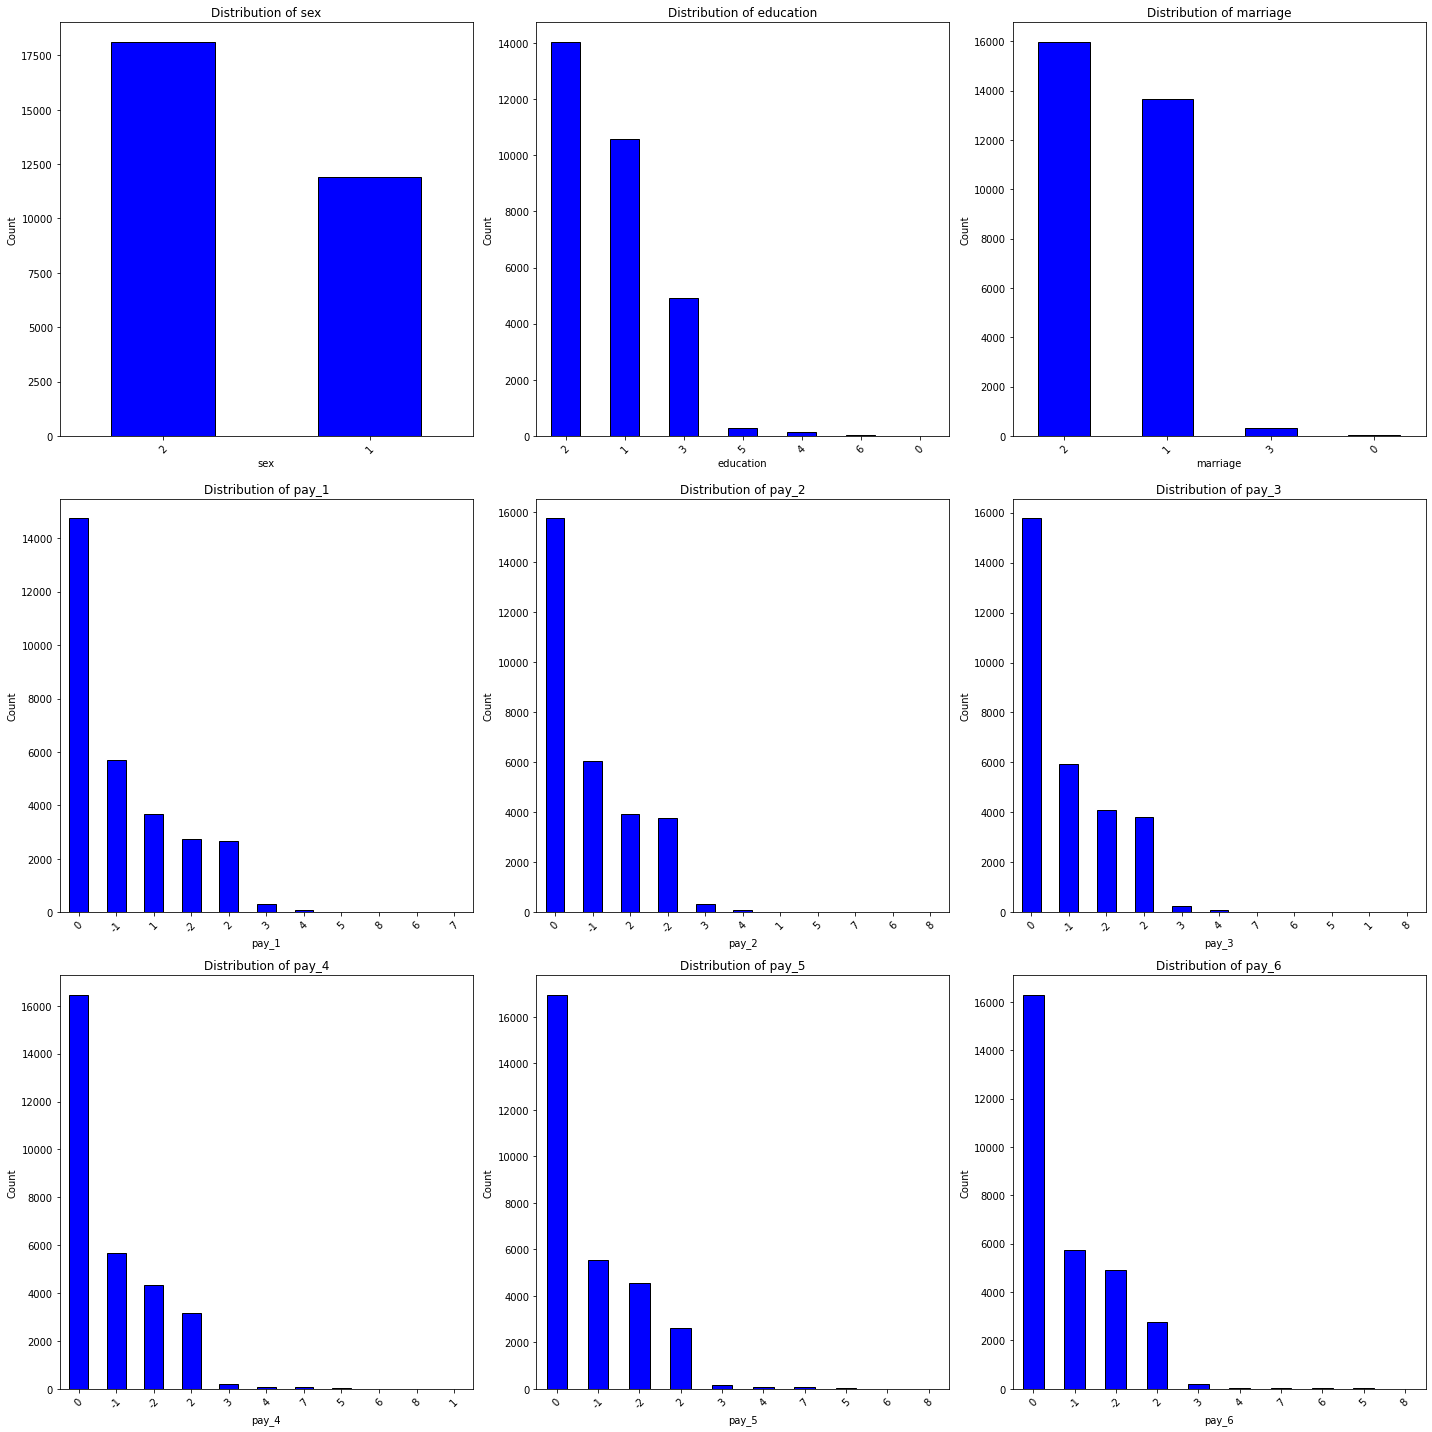

In [163]:
# bar charts for categorical data
plt.figure(figsize=(20,20))

cat_list = cat_vars.columns.unique()

for index, column in enumerate(cat_list):
  plt.subplot(3,3,index+1)
  (credit_df[column].value_counts()).plot.bar(color='b', ec='black')
  plt.title('Distribution of {}'.format(column))
  plt.ylabel('Count')
  plt.xlabel(column)
  plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Looks like there are categories of education and marriage that are not mentioned in the documentation. How many samples are misclassified?

In [164]:
len(credit_df[credit_df['education'] == 0])

14

In [165]:
len(credit_df[credit_df['marriage'] == 0])

54

I'm going to exclude these from the dataset because there are only 68 values and they are likely misclassified.

In [166]:
# removing 0 from marriage and education. Small number of samples and likely misclassified
credit_df = credit_df[credit_df['marriage'] != 0]
credit_df = credit_df[credit_df['education'] != 0]

Next, I want to group the 'Other' categories together as one 'Other category for pay and education.

In [167]:
m = {-2:[-2], -1:[-1], 0:[0], 1:[1], 2:[2], 3:[3,4,5,6,7,8]}
m2 = {v: k for k,vv in m.items() for v in vv}
m2

{-2: -2, -1: -1, 0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3}

In [168]:
credit_df.pay_1 = credit_df.pay_1.map(m2).astype('category')
credit_df.pay_2 = credit_df.pay_2.map(m2).astype('category')
credit_df.pay_3 = credit_df.pay_3.map(m2).astype('category')
credit_df.pay_4 = credit_df.pay_4.map(m2).astype('category')
credit_df.pay_5 = credit_df.pay_5.map(m2).astype('category')
credit_df.pay_6 = credit_df.pay_6.map(m2).astype('category')

In [169]:
n = {1:[1], 2:[2], 3:[3], 4:[4,5,6]}
n2 = {v: k for k,vv in n.items() for v in vv}
n2

{1: 1, 2: 2, 3: 3, 4: 4, 5: 4, 6: 4}

In [170]:
credit_df.education = credit_df.education.map(n2).astype('category')

Let's replot the categorical variables to look that the 

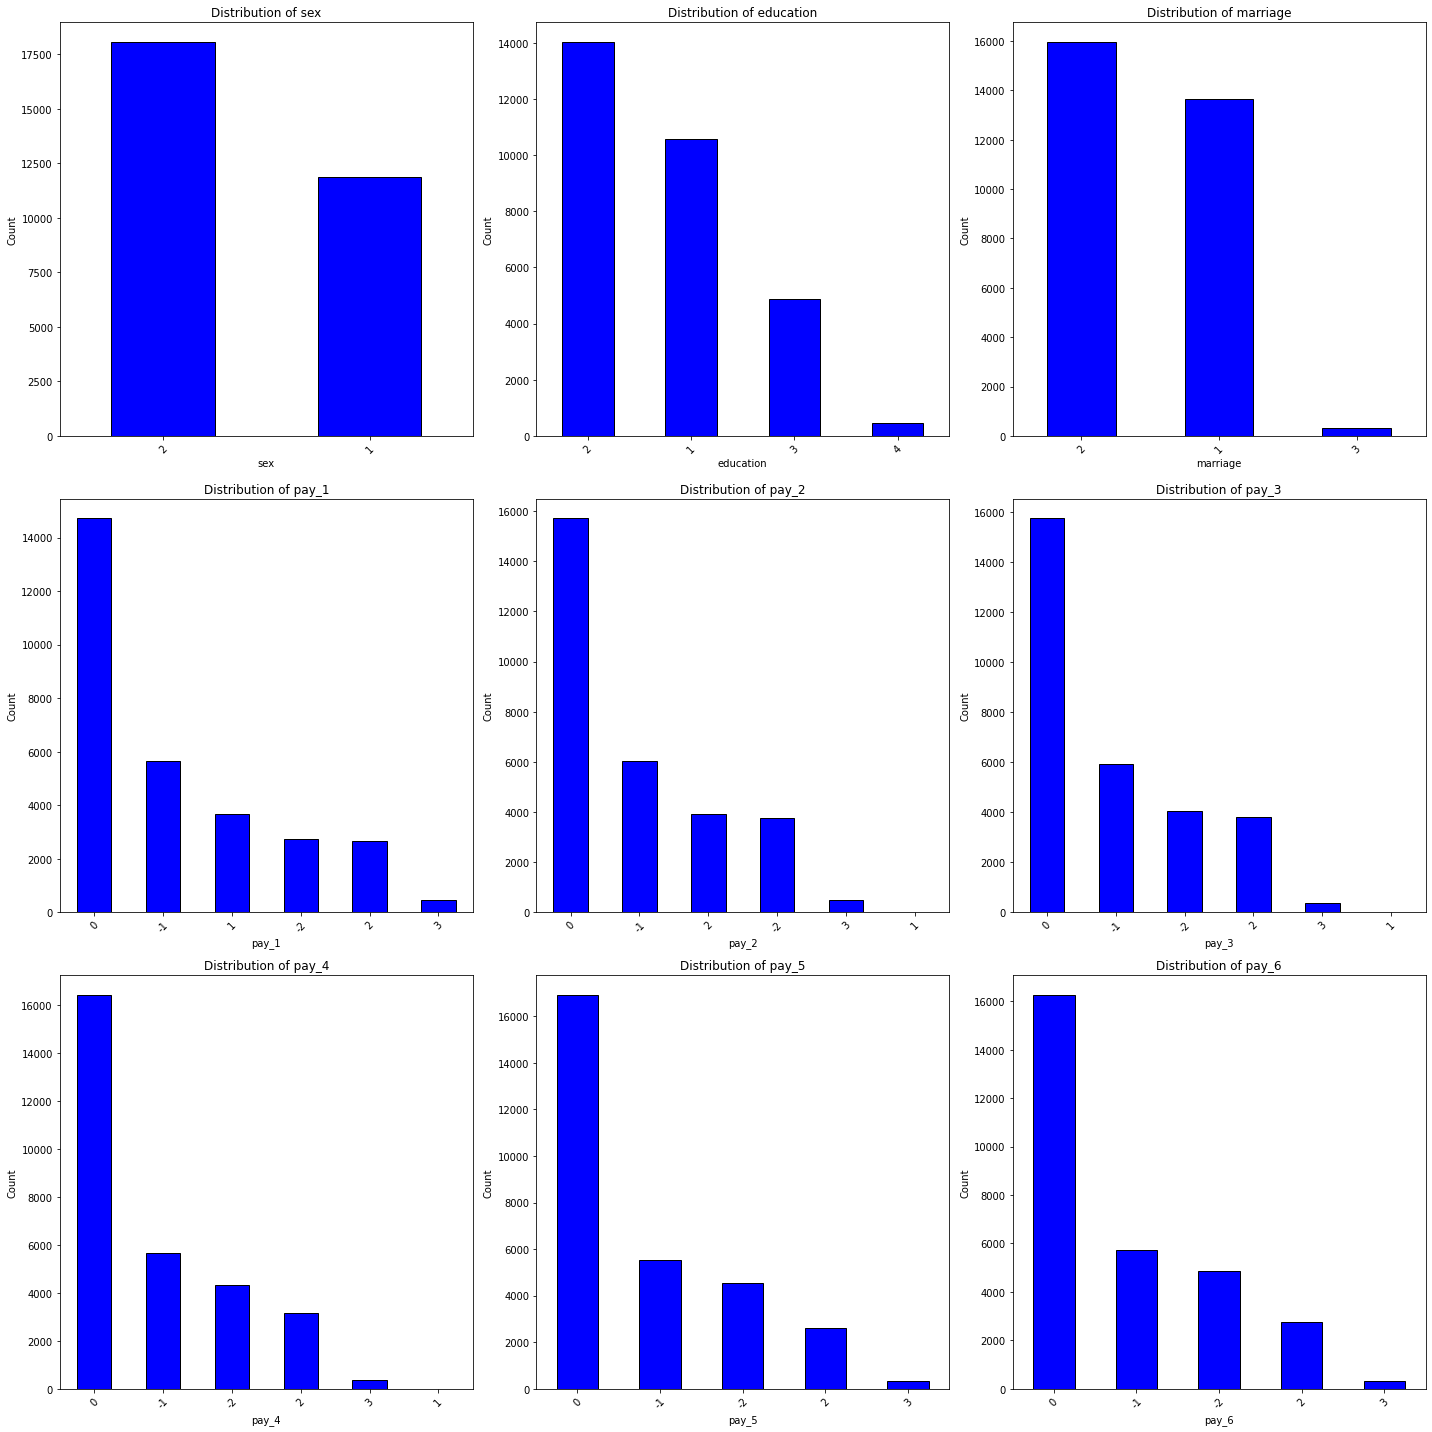

In [171]:
# bar charts for categorical data
plt.figure(figsize=(20,20))

cat_vars = credit_df.drop(columns=['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 
                                   'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 
                                   'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default'])

cat_list = cat_vars.columns.unique()

for index, column in enumerate(cat_list):
  plt.subplot(3,3,index+1)
  (credit_df[column].value_counts()).plot.bar(color='b', ec='black')
  plt.title('Distribution of {}'.format(column))
  plt.ylabel('Count')
  plt.xlabel(column)
  plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [172]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29932 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   limit_bal  29932 non-null  int64   
 1   sex        29932 non-null  object  
 2   education  29932 non-null  category
 3   marriage   29932 non-null  object  
 4   age        29932 non-null  int64   
 5   pay_1      29932 non-null  category
 6   pay_2      29932 non-null  category
 7   pay_3      29932 non-null  category
 8   pay_4      29932 non-null  category
 9   pay_5      29932 non-null  category
 10  pay_6      29932 non-null  category
 11  bill_amt1  29932 non-null  int64   
 12  bill_amt2  29932 non-null  int64   
 13  bill_amt3  29932 non-null  int64   
 14  bill_amt4  29932 non-null  int64   
 15  bill_amt5  29932 non-null  int64   
 16  bill_amt6  29932 non-null  int64   
 17  pay_amt1   29932 non-null  int64   
 18  pay_amt2   29932 non-null  int64   
 19  pay_amt3   29932 non-null

The strange part about this data set is that for 'pay_n' variables, there are two categories that are unlabeled in the documentation, 0 and -2. Will investigate further below.

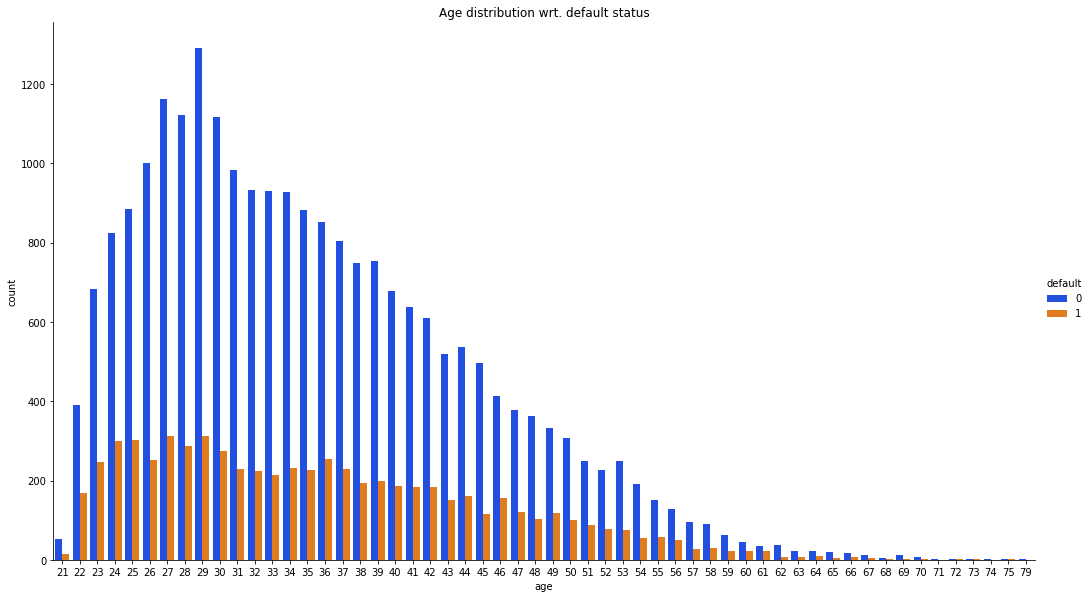

In [173]:
g = sns.catplot(x="age", hue="default",
                data=credit_df, kind="count", height=8, aspect=1.8, palette='bright').set(title='Age distribution wrt. default status')

Text(0.5, 1.0, 'Comparing credit limit w/ education')

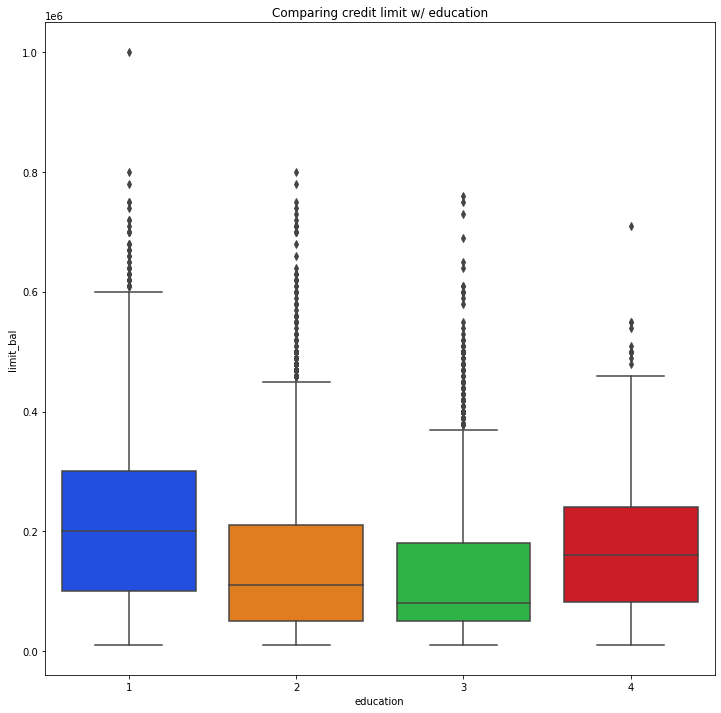

In [174]:
# change to boxplot
plt.figure(figsize=(12,12))

sns.set_palette('bright')
b = sns.boxplot(x=credit_df['education'], y=credit_df['limit_bal'])

new_title = 'Comparing credit limit w/ education'
b.set_title(new_title)

In [175]:
grouped_df = credit_df.groupby(['education']).agg({'limit_bal': ['mean', 'min', 'max']})
#grouped_df.columns = ['mean', 'min', 'max']
grouped_df.head(7)

limit_bal                
                mean    min      max
education                           
1         212,962.86  10000  1000000
2         147,040.50  10000   800000
3         126,623.78  10000   760000
4         180,211.45  10000   710000

Text(0.5, 1.0, 'Comparing credit limit and default status w/ sex')

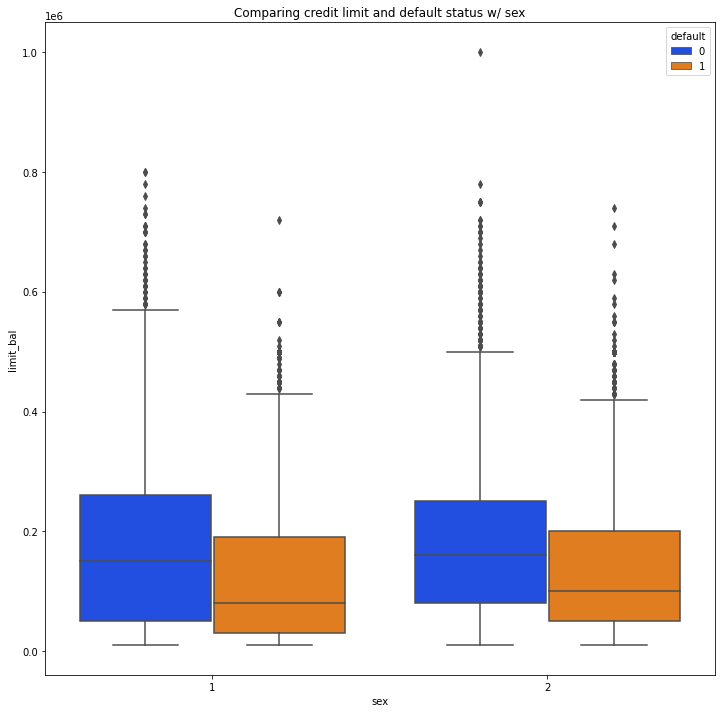

In [176]:
plt.figure(figsize=(12,12))

sns.set_palette('bright')
b = sns.boxplot(x=credit_df['sex'], y=credit_df['limit_bal'], hue=credit_df['default'])

new_title = 'Comparing credit limit and default status w/ sex'
b.set_title(new_title)

Text(0.5, 1.0, 'Distribution of credit limit wrt. default')

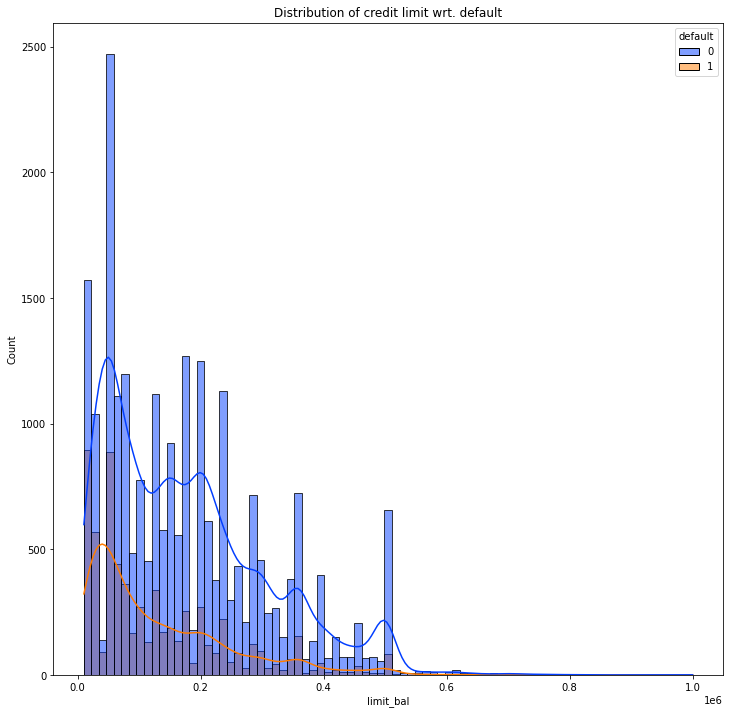

In [177]:
plt.figure(figsize=(12,12))
h = sns.histplot(x=credit_df['limit_bal'], hue=credit_df['default'], kde=True)

new_title = 'Distribution of credit limit wrt. default'
h.set_title(new_title)

Text(0.5, 1.0, 'Distribution of credit limit wrt. marriage status')

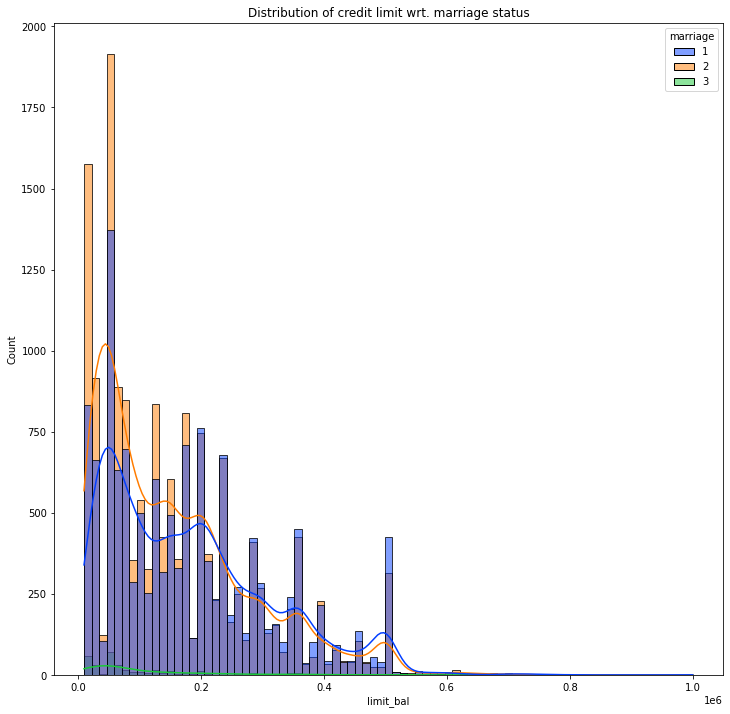

In [178]:
plt.figure(figsize=(12,12))

h = sns.histplot(x=credit_df['limit_bal'], hue=credit_df['marriage'], kde=True, palette='bright')

new_title = 'Distribution of credit limit wrt. marriage status'
h.set_title(new_title)

Let's look at the probability of default for each category

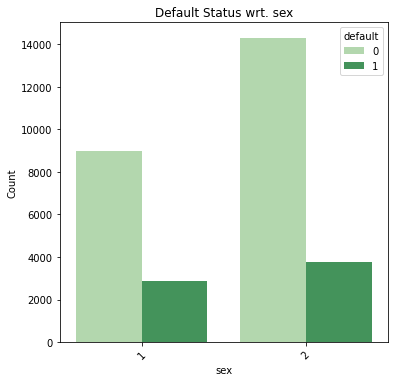

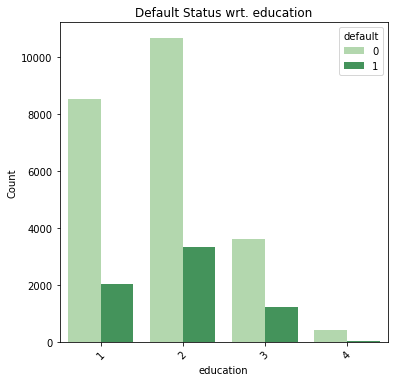

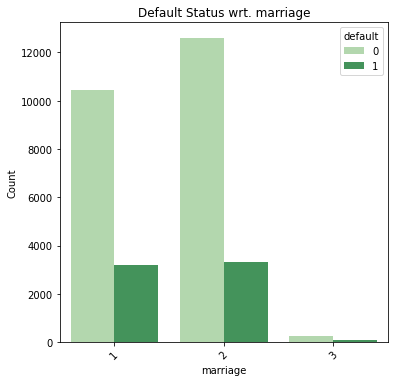

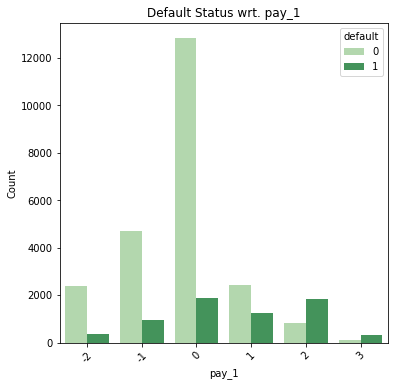

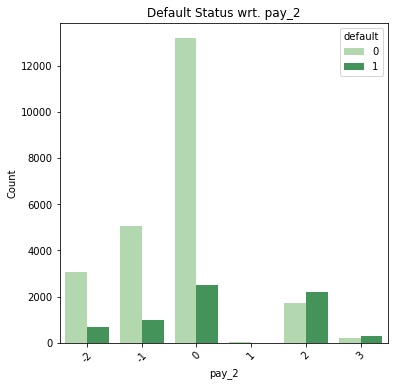

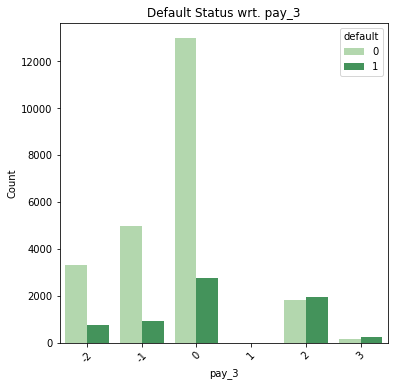

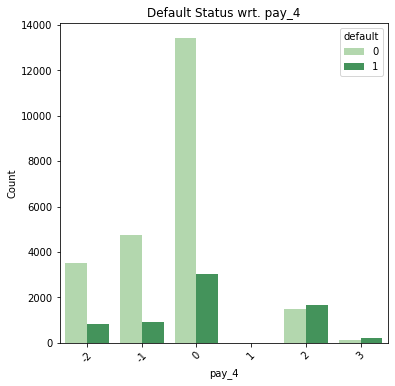

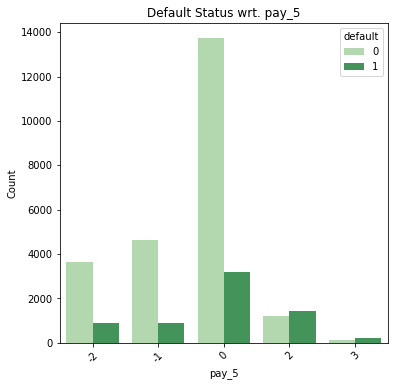

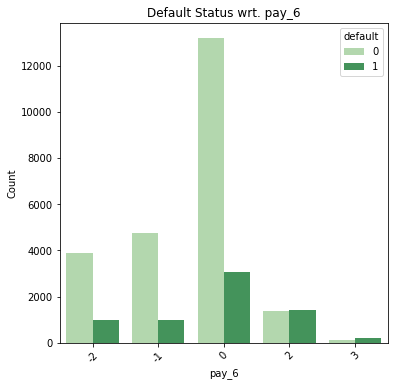

In [179]:
for index, column in enumerate(cat_list):
  plt.figure(figsize=(20,20))
  plt.subplot(3,3,index+1)
  sns.countplot(x=column, hue="default", data=credit_df, palette='Greens')
  plt.title('Default Status wrt. {}'.format(column))
  plt.ylabel('Count')
  plt.xlabel(column)
  plt.xticks(rotation=45)


Investigating the existence of 0 and -2 for 'pay_n' variables. What is the relationship to bill amount and payment amount?

In [180]:
pb = [a for a in credit_df if a.startswith('pay') | a.startswith('bill')]
pay_and_bill = credit_df[pb]
pay_and_bill.head(35)  

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
1,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
2,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679
6,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800
7,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770
8,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542
9,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000
10,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0


After spending some time comparing payment status categories and bill/payment amounts, as well as additional research on Kaggle [7], I have a better understanding the categories for -2 and 0. -2 means the individual for that month did not have a bill. I confirmed this in the table above looking at payment amounts and bill amounts for months denoted as -2. Accoring to the Kaggle discussion, 0 means that the individual used revolving credit for a particular month. After further research revolving credit means the person paid the minimum credit card payment.

Creating two DataFrames for comparison of payment amounts and bill amounts. Will use these to create a percent bill paid feature.

In [181]:
pay_amt = [p for p in credit_df if p.startswith('pay_amt')]
pay_amt_df = credit_df[pay_amt]
pay_amt_df.describe()

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,"29,932.00","29,932.00","29,932.00","29,932.00","29,932.00","29,932.00"
mean,"5,659.60","5,923.50","5,226.16","4,830.18","4,805.27","5,221.91"
std,"16,555.87","23,060.20","17,620.77","15,680.85","15,294.07","17,795.29"
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,"1,000.00",836.00,390.00,298.00,255.00,122.00
50%,"2,100.00","2,010.00","1,800.00","1,500.00","1,500.00","1,500.00"
75%,"5,006.00","5,000.00","4,507.25","4,015.00","4,040.25","4,000.00"
max,"873,552.00","1,684,259.00","896,040.00","621,000.00","426,529.00","528,666.00"


In [182]:
bill_amt = [b for b in credit_df if b.startswith('bill_amt')]
bill_amt_df = credit_df[bill_amt]
bill_amt_df.describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
count,"29,932.00","29,932.00","29,932.00","29,932.00","29,932.00","29,932.00"
mean,"51,297.39","49,242.86","47,077.03","43,320.70","40,367.55","38,927.27"
std,"73,694.49","71,230.37","69,404.73","64,385.86","60,845.49","59,601.23"
min,"-165,580.00","-69,777.00","-157,264.00","-170,000.00","-81,334.00","-339,603.00"
25%,"3,577.00","2,989.75","2,685.50","2,339.75","1,772.75","1,261.00"
50%,"22,420.50","21,234.50","20,111.50","19,068.50","18,125.50","17,111.50"
75%,"67,283.50","64,136.00","60,252.50","54,613.25","50,253.50","49,260.25"
max,"964,511.00","983,931.00","1,664,089.00","891,586.00","927,171.00","961,664.00"


## Feature Engineering

Creating a feature for the percentage of the bill the customer paid for a given month. Note: What i've noticed is that the payment amount month lags the bill amount month by one month. The code below reflects this payment lag.

In [183]:
credit_df['pct_paidbill2'] = (pay_amt_df['pay_amt1']/bill_amt_df['bill_amt2'])*100
credit_df['pct_paidbill3'] = (pay_amt_df['pay_amt2']/bill_amt_df['bill_amt3'])*100
credit_df['pct_paidbill4'] = (pay_amt_df['pay_amt3']/bill_amt_df['bill_amt4'])*100
credit_df['pct_paidbill5'] = (pay_amt_df['pay_amt4']/bill_amt_df['bill_amt5'])*100
credit_df['pct_paidbill6'] = (pay_amt_df['pay_amt5']/bill_amt_df['bill_amt6'])*100

Next, I want to create a feature for the percent of credit limit used by a customer. Frequently, credit monitoring company's look at the percent of credit used per month by a customer. This is referred to as credit utilization. If a person's credit utilization is too high, this will reflect negatively in the their credit score. This might be a good predictor of a person's risk for default.

In [184]:
credit_df['credit_util1'] = (bill_amt_df['bill_amt1']/credit_df['limit_bal'])*100
credit_df['credit_util2'] = (bill_amt_df['bill_amt2']/credit_df['limit_bal'])*100
credit_df['credit_util3'] = (bill_amt_df['bill_amt3']/credit_df['limit_bal'])*100
credit_df['credit_util4'] = (bill_amt_df['bill_amt4']/credit_df['limit_bal'])*100
credit_df['credit_util5'] = (bill_amt_df['bill_amt5']/credit_df['limit_bal'])*100
credit_df['credit_util6'] = (bill_amt_df['bill_amt6']/credit_df['limit_bal'])*100

In [185]:
credit_df = credit_df.replace(np.inf, np.nan)
credit_df = credit_df.replace(np.nan, 200)

In [186]:
credit_df.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,pct_paidbill2,pct_paidbill3,pct_paidbill4,pct_paidbill5,pct_paidbill6,credit_util1,credit_util2,credit_util3,credit_util4,credit_util5,credit_util6
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.00,100.00,200.00,200.00,200.00,19.56,15.51,3.45,0.00,0.00,0.00
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0.00,37.29,30.56,28.94,0.00,2.23,1.44,2.23,2.73,2.88,2.72
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,10.82,11.06,6.98,6.69,6.43,32.49,15.59,15.07,15.92,16.61,17.28
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,4.15,4.10,4.24,3.80,3.62,93.98,96.47,98.58,56.63,57.92,59.09
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,35.27,102.36,47.76,47.01,3.60,17.23,11.34,71.67,41.88,38.29,38.26


Many of the distributions are highly skewed to the right. Creating box plots for each variable to understand the amount of outliers. 

In [187]:
q75, q25 = np.percentile(credit_df['bill_amt1'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((credit_df['limit_bal'] > max_val) 
                      | (credit_df['limit_bal'] < min_val))[0]))))

The score threshold is: 1.0
Number of outliers is: 15423
The score threshold is: 1.5
Number of outliers is: 12876
The score threshold is: 2.0
Number of outliers is: 11124
The score threshold is: 2.5
Number of outliers is: 8410
The score threshold is: 3.0
Number of outliers is: 6709
The score threshold is: 3.5
Number of outliers is: 5112
The score threshold is: 4.0
Number of outliers is: 3976
The score threshold is: 4.5
Number of outliers is: 3355


The distribution of the bill amounts has many outliers on both ends of the distribution. I'll winsorize these variables to handle the outliers. I'll add these outliers to the 5th and 95th percentiles of the data.

In [188]:
# winsorize bill amounts
winsor_list = bill_amt_df.columns.unique()

for d in winsor_list:
    credit_df['winsorized_{}'.format(d)] = winsorize(credit_df[d], limits=[0.05, 0.05])
    #credit_df = credit_df.drop(columns=d)

In [189]:
q75, q25 = np.percentile(credit_df['winsorized_bill_amt1'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((credit_df['winsorized_bill_amt1'] > max_val) 
                      | (credit_df['winsorized_bill_amt1'] < min_val))[0]))))

The score threshold is: 1.0
Number of outliers is: 3467
The score threshold is: 1.5
Number of outliers is: 2381
The score threshold is: 2.0
Number of outliers is: 1638
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


Comparing bill amount1 before and after the winsorization, the outliers are significantly reduced.

Looking at the credit utilization features created, I notice that some customers have greater than 100% credit utilization each month. After some research [3] I learn that a person can exceed his or her credit limit, but it requires calling the bank and either a. getting approval for a specific purchase that will exceed the limit or b. remove the penalty and card decline from the account. I assume there is some type of review process by the bank for allowing customers to exceed a limit. I'm going to look at the distribution of individuals that exceed their limit and whether or not they default.  

In [190]:
util_list = [c for c in credit_df if c.startswith('credit')]

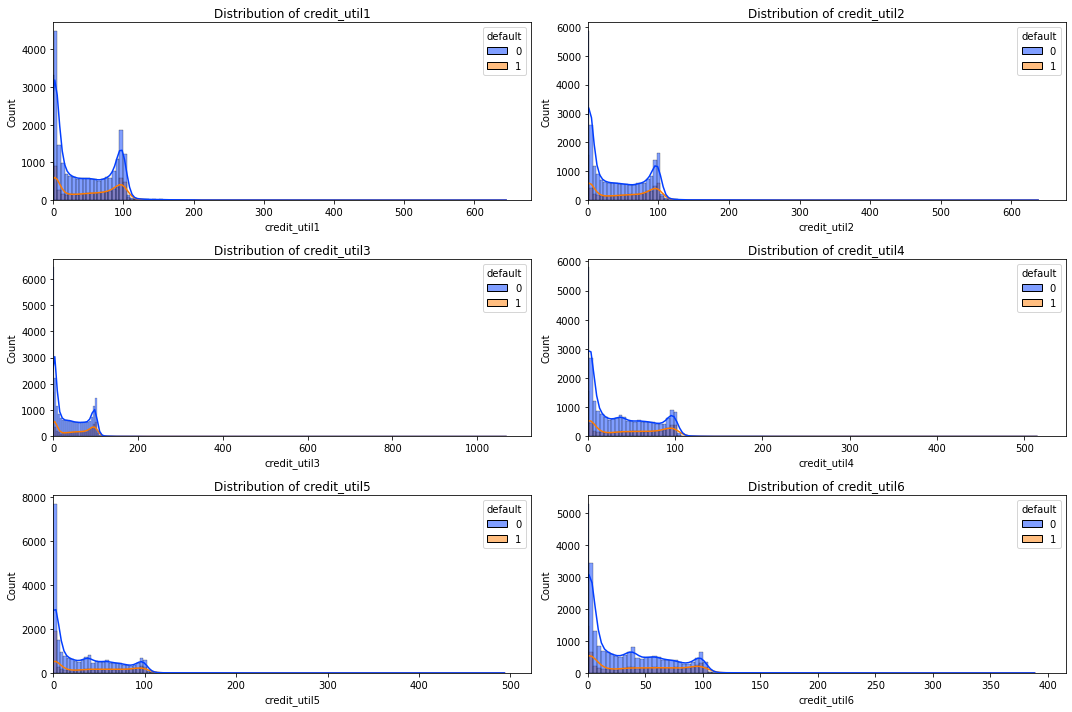

In [191]:
# numerical data histograms after cleaning data
plt.figure(figsize=(15, 10))

for index, column in enumerate(util_list):
  plt.subplot(3,2,index+1)
  sns.histplot(data=credit_df, x=column, hue='default', kde=True)
  plt.title('Distribution of {}'.format(column))
  plt.xlim(left=0)

plt.tight_layout()
plt.show()

In [192]:
credit_df.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,pct_paidbill2,pct_paidbill3,pct_paidbill4,pct_paidbill5,pct_paidbill6,credit_util1,credit_util2,credit_util3,credit_util4,credit_util5,credit_util6,winsorized_bill_amt1,winsorized_bill_amt2,winsorized_bill_amt3,winsorized_bill_amt4,winsorized_bill_amt5,winsorized_bill_amt6
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.00,100.00,200.00,200.00,200.00,19.56,15.51,3.45,0.00,0.00,0.00,3913,3102,689,0,0,0
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0.00,37.29,30.56,28.94,0.00,2.23,1.44,2.23,2.73,2.88,2.72,2682,1725,2682,3272,3455,3261
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,10.82,11.06,6.98,6.69,6.43,32.49,15.59,15.07,15.92,16.61,17.28,29239,14027,13559,14331,14948,15549
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,4.15,4.10,4.24,3.80,3.62,93.98,96.47,98.58,56.63,57.92,59.09,46990,48233,49291,28314,28959,29547
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,35.27,102.36,47.76,47.01,3.60,17.23,11.34,71.67,41.88,38.29,38.26,8617,5670,35835,20940,19146,19131


I'm going to create a few new features from existing pay and bill amounts. Total_pay is the sum of the 6 months of payments. Total_bill is the sum of the 6 months of bills. Pct_bill_paid is the total percentage of bill paid by a customer over the course of 6 months.

In [193]:
credit_df['total_pay'] = credit_df['pay_amt1'] + credit_df['pay_amt2'] + credit_df['pay_amt3'] + credit_df['pay_amt4'] + credit_df['pay_amt5'] + credit_df['pay_amt6']
credit_df['total_bill'] = credit_df['bill_amt1'] + credit_df['bill_amt2'] + credit_df['bill_amt3'] + credit_df['bill_amt4'] + credit_df['bill_amt5'] + credit_df['bill_amt6']
credit_df['pct_bill_paid'] = (credit_df['total_pay']/credit_df['total_bill']) * 100
credit_df.head(5)

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,pct_paidbill2,pct_paidbill3,pct_paidbill4,pct_paidbill5,pct_paidbill6,credit_util1,credit_util2,credit_util3,credit_util4,credit_util5,credit_util6,winsorized_bill_amt1,winsorized_bill_amt2,winsorized_bill_amt3,winsorized_bill_amt4,winsorized_bill_amt5,winsorized_bill_amt6,total_pay,total_bill,pct_bill_paid
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.00,100.00,200.00,200.00,200.00,19.56,15.51,3.45,0.00,0.00,0.00,3913,3102,689,0,0,0,689,7704,8.94
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0.00,37.29,30.56,28.94,0.00,2.23,1.44,2.23,2.73,2.88,2.72,2682,1725,2682,3272,3455,3261,5000,17077,29.28
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,10.82,11.06,6.98,6.69,6.43,32.49,15.59,15.07,15.92,16.61,17.28,29239,14027,13559,14331,14948,15549,11018,101653,10.84
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,4.15,4.10,4.24,3.80,3.62,93.98,96.47,98.58,56.63,57.92,59.09,46990,48233,49291,28314,28959,29547,8388,231334,3.63
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,35.27,102.36,47.76,47.01,3.60,17.23,11.34,71.67,41.88,38.29,38.26,8617,5670,35835,20940,19146,19131,59049,109339,54.01


I'm going to double check to see if there are any null values in the feature I just created.

In [194]:
credit_df.isnull().sum().sort_values(ascending=False)

pct_bill_paid           793
total_bill                0
pay_amt3                  0
pay_amt2                  0
pay_amt1                  0
bill_amt6                 0
bill_amt5                 0
bill_amt4                 0
bill_amt3                 0
bill_amt2                 0
bill_amt1                 0
pay_6                     0
pay_5                     0
pay_4                     0
pay_3                     0
pay_2                     0
pay_1                     0
age                       0
marriage                  0
education                 0
sex                       0
pay_amt4                  0
pay_amt5                  0
pay_amt6                  0
credit_util5              0
total_pay                 0
winsorized_bill_amt6      0
winsorized_bill_amt5      0
winsorized_bill_amt4      0
winsorized_bill_amt3      0
winsorized_bill_amt2      0
winsorized_bill_amt1      0
credit_util6              0
credit_util4              0
default                   0
credit_util3        

Looks like there are 793 null values for the 'pct_bill_paid' feature. I'll replace these nulls with 200 (or 200% of the bill paid). These values are null because the person for this month does not have a bill. In many cases the individual pays a certain amount even if they have no bill.

In [195]:
credit_df = credit_df.replace(np.inf, np.nan)
credit_df = credit_df.replace(np.nan, 200)

In [196]:
credit_df.isnull().sum().sort_values(ascending=False)

pct_bill_paid           0
total_bill              0
pay_amt3                0
pay_amt2                0
pay_amt1                0
bill_amt6               0
bill_amt5               0
bill_amt4               0
bill_amt3               0
bill_amt2               0
bill_amt1               0
pay_6                   0
pay_5                   0
pay_4                   0
pay_3                   0
pay_2                   0
pay_1                   0
age                     0
marriage                0
education               0
sex                     0
pay_amt4                0
pay_amt5                0
pay_amt6                0
credit_util5            0
total_pay               0
winsorized_bill_amt6    0
winsorized_bill_amt5    0
winsorized_bill_amt4    0
winsorized_bill_amt3    0
winsorized_bill_amt2    0
winsorized_bill_amt1    0
credit_util6            0
credit_util4            0
default                 0
credit_util3            0
credit_util2            0
credit_util1            0
pct_paidbill

Need to create dummy variables for categorical data.

In [197]:
for x in cat_list:
    credit_df = pd.concat([credit_df, pd.get_dummies(credit_df[x], prefix=x, drop_first=True)], axis=1)

credit_df.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,pct_paidbill2,pct_paidbill3,pct_paidbill4,pct_paidbill5,pct_paidbill6,credit_util1,credit_util2,credit_util3,credit_util4,credit_util5,credit_util6,winsorized_bill_amt1,winsorized_bill_amt2,winsorized_bill_amt3,winsorized_bill_amt4,winsorized_bill_amt5,winsorized_bill_amt6,total_pay,total_bill,pct_bill_paid,sex_2,education_2,education_3,education_4,marriage_2,marriage_3,pay_1_-1,pay_1_0,pay_1_1,pay_1_2,pay_1_3,pay_2_-1,pay_2_0,pay_2_1,pay_2_2,pay_2_3,pay_3_-1,pay_3_0,pay_3_1,pay_3_2,pay_3_3,pay_4_-1,pay_4_0,pay_4_1,pay_4_2,pay_4_3,pay_5_-1,pay_5_0,pay_5_2,pay_5_3,pay_6_-1,pay_6_0,pay_6_2,pay_6_3
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.00,100.00,200.00,200.00,200.00,19.56,15.51,3.45,0.00,0.00,0.00,3913,3102,689,0,0,0,689,7704,8.94,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0.00,37.29,30.56,28.94,0.00,2.23,1.44,2.23,2.73,2.88,2.72,2682,1725,2682,3272,3455,3261,5000,17077,29.28,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,10.82,11.06,6.98,6.69,6.43,32.49,15.59,15.07,15.92,16.61,17.28,29239,14027,13559,14331,14948,15549,11018,101653,10.84,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,4.15,4.10,4.24,3.80,3.62,93.98,96.47,98.58,56.63,57.92,59.09,46990,48233,49291,28314,28959,29547,8388,231334,3.63,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,35.27,102.36,47.76,47.01,3.60,17.23,11.34,71.67,41.88,38.29,38.26,8617,5670,35835,20940,19146,19131,59049,109339,54.01,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0


Remove dummy inputs

In [198]:
credit_df = credit_df.drop(columns=['sex', 'education', 'marriage', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'])

In [199]:
credit_df.head()

,limit_bal,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,pct_paidbill2,pct_paidbill3,pct_paidbill4,pct_paidbill5,pct_paidbill6,credit_util1,credit_util2,credit_util3,credit_util4,credit_util5,credit_util6,winsorized_bill_amt1,winsorized_bill_amt2,winsorized_bill_amt3,winsorized_bill_amt4,winsorized_bill_amt5,winsorized_bill_amt6,total_pay,total_bill,pct_bill_paid,sex_2,education_2,education_3,education_4,marriage_2,marriage_3,pay_1_-1,pay_1_0,pay_1_1,pay_1_2,pay_1_3,pay_2_-1,pay_2_0,pay_2_1,pay_2_2,pay_2_3,pay_3_-1,pay_3_0,pay_3_1,pay_3_2,pay_3_3,pay_4_-1,pay_4_0,pay_4_1,pay_4_2,pay_4_3,pay_5_-1,pay_5_0,pay_5_2,pay_5_3,pay_6_-1,pay_6_0,pay_6_2,pay_6_3
1,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.00,100.00,200.00,200.00,200.00,19.56,15.51,3.45,0.00,0.00,0.00,3913,3102,689,0,0,0,689,7704,8.94,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0.00,37.29,30.56,28.94,0.00,2.23,1.44,2.23,2.73,2.88,2.72,2682,1725,2682,3272,3455,3261,5000,17077,29.28,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,10.82,11.06,6.98,6.69,6.43,32.49,15.59,15.07,15.92,16.61,17.28,29239,14027,13559,14331,14948,15549,11018,101653,10.84,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,4.15,4.10,4.24,3.80,3.62,93.98,96.47,98.58,56.63,57.92,59.09,46990,48233,49291,28314,28959,29547,8388,231334,3.63,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
5,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,35.27,102.36,47.76,47.01,3.60,17.23,11.34,71.67,41.88,38.29,38.26,8617,5670,35835,20940,19146,19131,59049,109339,54.01,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0


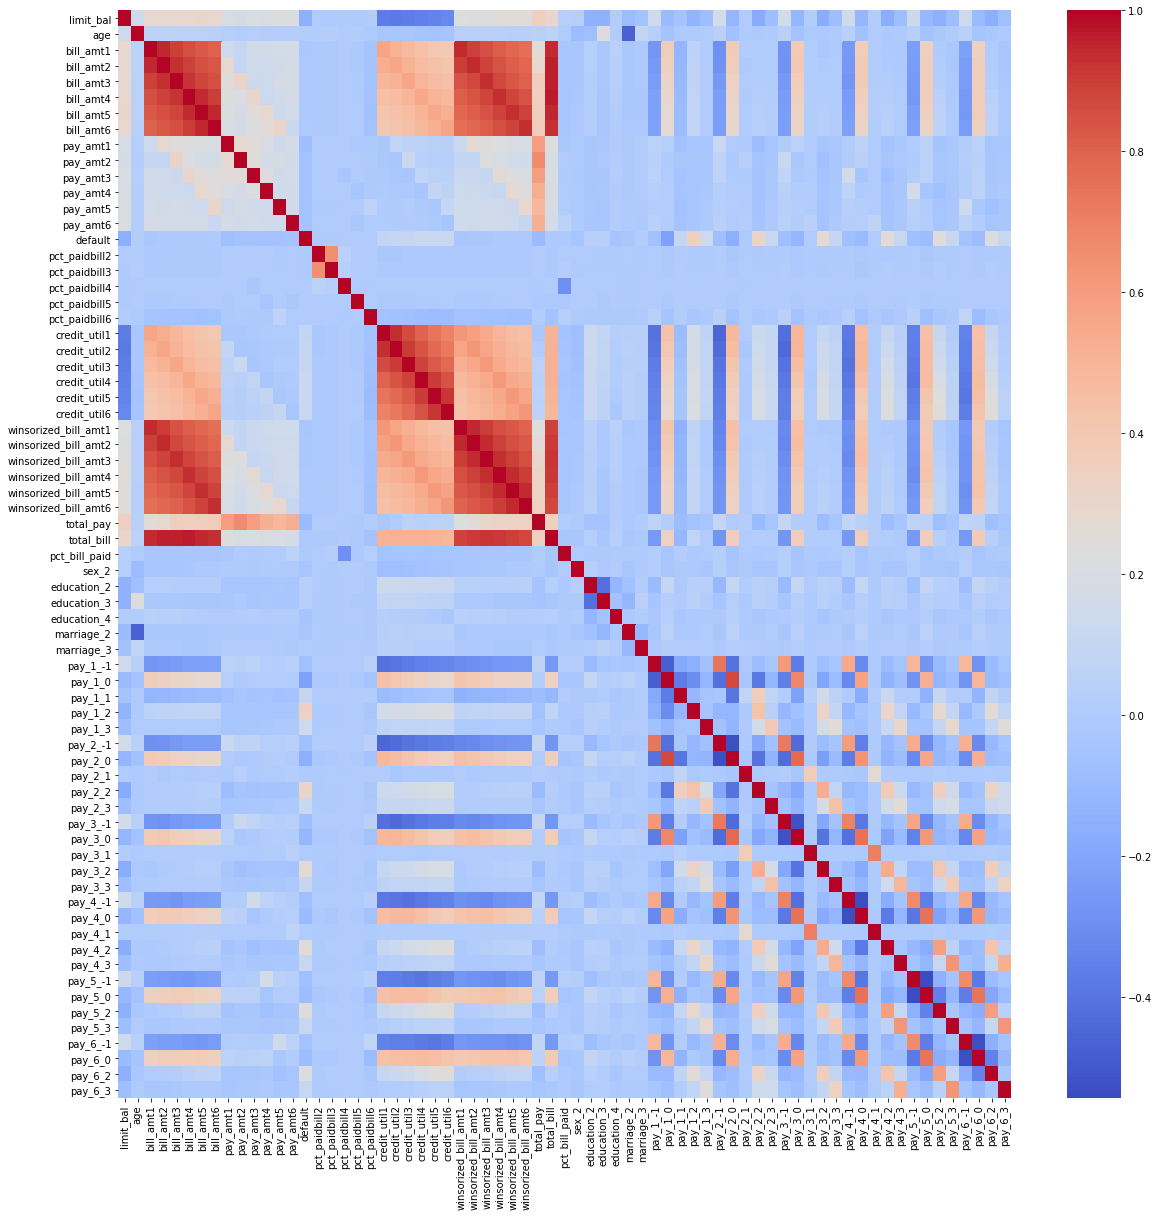

In [200]:
plt.figure(figsize=(20,20))
sns.heatmap(credit_df.corr(), cmap='coolwarm', cbar=True)

In [201]:
len(credit_df.columns.unique())

69

## Principal Components Analysis (PCA)

In [202]:
X = credit_df.drop(columns='default')

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=0.95) # keep variables the explain 95% of the variance

In [203]:
sklearn_pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [204]:
len(sklearn_pca.explained_variance_ratio_)

39

In [205]:
X_transform = sklearn_pca.fit_transform(X) # transformed variable with 39 principle components

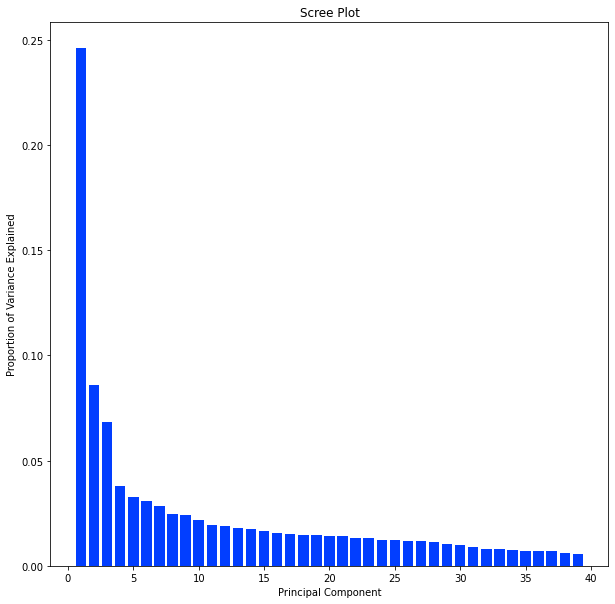

In [206]:
pca_vals = np.arange(sklearn_pca.n_components_) + 1
plt.figure(figsize=(10,10))
plt.bar(pca_vals, sklearn_pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

## Supervised ML Models
I'm going to be implementing several models to predict the target variable. This section will use Logistic Regression, KNN Classifiers, Random Forrests, and Boosting. 

In [207]:
# split data into features and target variable
X = X_transform
y = credit_df['default']

#### *Initial Models*

Split the data into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

I've borrowed this function from Scikit-learn documentation. It will plot confusion matrices for each model.

In [208]:
# confusion matrix code taken from scikit-learn [6].
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

print('Train Accuracy Score: %s' % lr.score(X_train, y_train))
print('Test Accuracy Score: %s' % lr.score(X_test, y_test))
print('# of iterations %s' % lr.n_iter_[0])

Train Accuracy Score: 0.8193359782835665
Test Accuracy Score: 0.8145982963086688
# of iterations 47


In [ ]:
Train_predictions = lr.predict(X_train)
Test_predictions = lr.predict(X_test)

train_confusion = confusion_matrix(y_train, Train_predictions, labels=[1,0])
test_confusion = confusion_matrix(y_test, Test_predictions, labels=[1,0])
print(train_confusion)
print(test_confusion)

[[ 1787  3475]
 [  851 17832]]
[[ 466  903]
 [ 207 4411]]


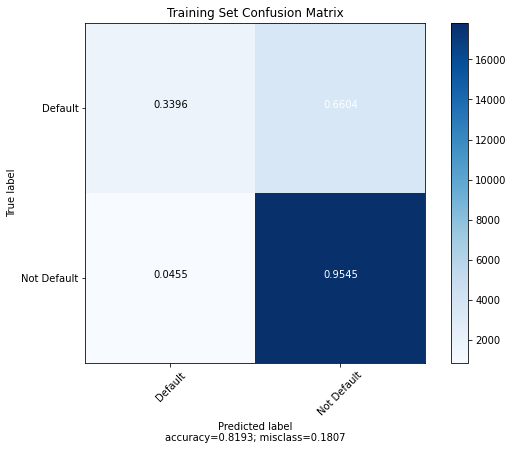

In [ ]:
plot_confusion_matrix(cm=train_confusion, target_names = ['Default', 'Not Default'], title = 'Training Set Confusion Matrix',normalize=True)

In [ ]:
report = classification_report(y_train, Train_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.84      0.95      0.89     18683
     Default       0.68      0.34      0.45      5262

    accuracy                           0.82     23945
   macro avg       0.76      0.65      0.67     23945
weighted avg       0.80      0.82      0.80     23945



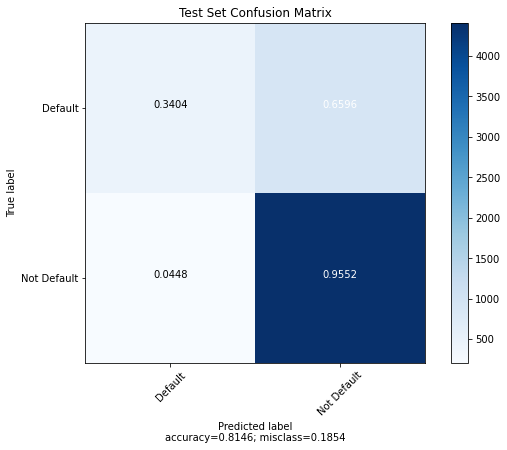

In [ ]:
plot_confusion_matrix(cm=test_confusion, target_names = ['Default', 'Not Default'], title = 'Test Set Confusion Matrix',normalize=True)

In [ ]:
report = classification_report(y_test, Test_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.83      0.96      0.89      4618
     Default       0.69      0.34      0.46      1369

    accuracy                           0.81      5987
   macro avg       0.76      0.65      0.67      5987
weighted avg       0.80      0.81      0.79      5987



KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 45)
knn.fit(X_train,y_train)

print('training score: {:.3f}'.format(knn.score(X_train, y_train)))
print('test score: {:.3f}'.format(knn.score(X_test, y_test)))

training score: 0.821
test score: 0.816


In [ ]:
Train_predictions = knn.predict(X_train)
Test_predictions = knn.predict(X_test)

train_confusion = confusion_matrix(y_train, Train_predictions, labels=[1,0])
test_confusion = confusion_matrix(y_test, Test_predictions, labels=[1,0])
print(train_confusion)
print(test_confusion)

[[ 1873  3389]
 [  895 17788]]
[[ 495  874]
 [ 226 4392]]


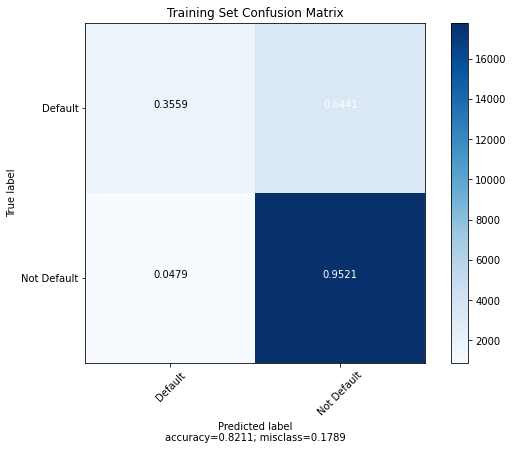

In [ ]:
plot_confusion_matrix(cm=train_confusion, target_names = ['Default', 'Not Default'], title = 'Training Set Confusion Matrix',normalize=True)

In [ ]:
report = classification_report(y_train, Train_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.84      0.95      0.89     18683
     Default       0.68      0.36      0.47      5262

    accuracy                           0.82     23945
   macro avg       0.76      0.65      0.68     23945
weighted avg       0.80      0.82      0.80     23945



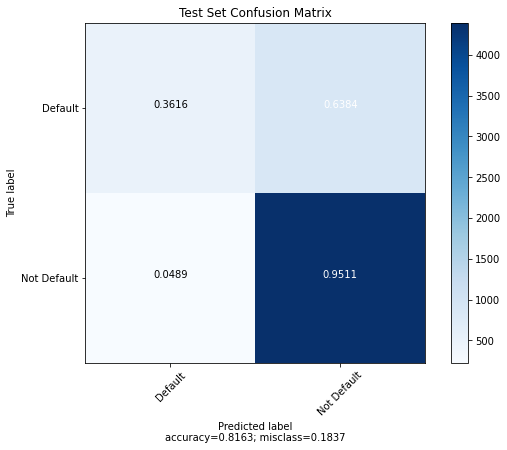

In [ ]:
plot_confusion_matrix(cm=test_confusion, target_names = ['Default', 'Not Default'], title = 'Test Set Confusion Matrix',normalize=True)

In [ ]:
report = classification_report(y_test, Test_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.83      0.95      0.89      4618
     Default       0.69      0.36      0.47      1369

    accuracy                           0.82      5987
   macro avg       0.76      0.66      0.68      5987
weighted avg       0.80      0.82      0.79      5987



Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = ensemble.RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)

print('Training score: %s' % np.mean(cross_val_score(rfc, X_train, y_train, cv=10)))
print('Test score: %s' % np.mean(cross_val_score(rfc, X_test, y_test, cv=10)))

Training score: 0.8016704949569471
Test score: 0.796556133131585


In [ ]:
Train_predictions = rfc.predict(X_train)
Test_predictions = rfc.predict(X_test)

train_confusion = confusion_matrix(y_train, Train_predictions, labels=[1,0])
test_confusion = confusion_matrix(y_test, Test_predictions, labels=[1,0])
print(train_confusion)
print(test_confusion)

[[ 4773   489]
 [   33 18650]]
[[ 459  910]
 [ 279 4339]]


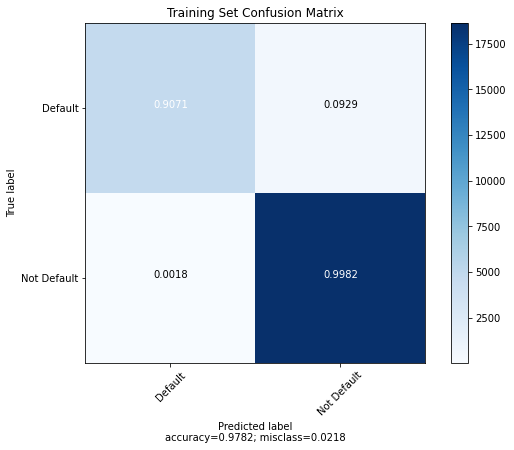

In [ ]:
plot_confusion_matrix(cm=train_confusion, target_names = ['Default', 'Not Default'], title = 'Training Set Confusion Matrix',normalize=True)

In [ ]:
report = classification_report(y_train, Train_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.97      1.00      0.99     18683
     Default       0.99      0.91      0.95      5262

    accuracy                           0.98     23945
   macro avg       0.98      0.95      0.97     23945
weighted avg       0.98      0.98      0.98     23945



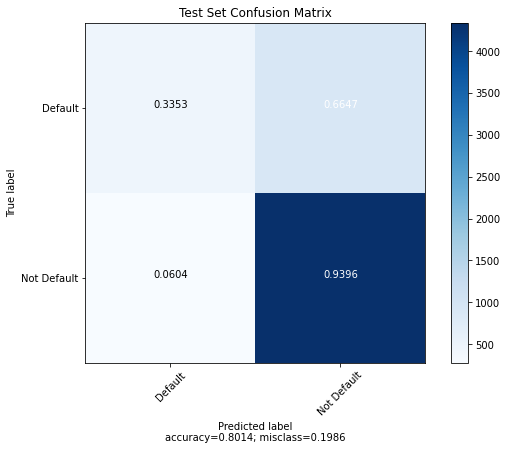

In [ ]:
plot_confusion_matrix(cm=test_confusion, target_names = ['Default', 'Not Default'], title = 'Test Set Confusion Matrix',normalize=True)

In [ ]:
report = classification_report(y_test, Test_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.83      0.94      0.88      4618
     Default       0.62      0.34      0.44      1369

    accuracy                           0.80      5987
   macro avg       0.72      0.64      0.66      5987
weighted avg       0.78      0.80      0.78      5987



Gradient Boost

In [ ]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

print('training score: {:.3f}'.format(clf.score(X_train, y_train)))
print('test score: {:.3f}'.format(clf.score(X_test, y_test)))

training score: 0.838
test score: 0.816


In [ ]:
Train_predictions = clf.predict(X_train)
Test_predictions = clf.predict(X_test)

train_confusion = confusion_matrix(y_train, Train_predictions, labels=[1,0])
test_confusion = confusion_matrix(y_test, Test_predictions, labels=[1,0])
print(train_confusion)
print(test_confusion)

[[ 2123  3139]
 [  738 17945]]
[[ 498  871]
 [ 231 4387]]


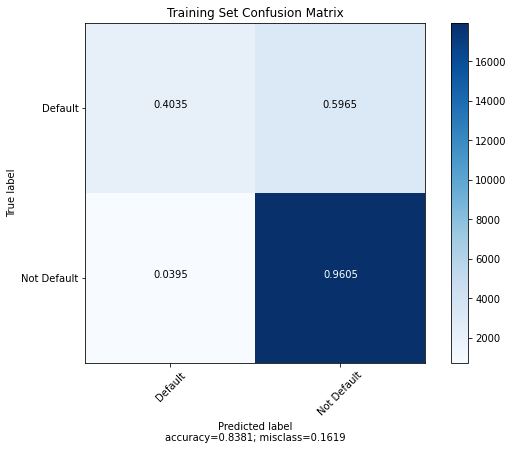

In [ ]:
plot_confusion_matrix(cm=train_confusion, target_names = ['Default', 'Not Default'], title = 'Training Set Confusion Matrix',normalize=True)

In [ ]:
report = classification_report(y_train, Train_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.85      0.96      0.90     18683
     Default       0.74      0.40      0.52      5262

    accuracy                           0.84     23945
   macro avg       0.80      0.68      0.71     23945
weighted avg       0.83      0.84      0.82     23945



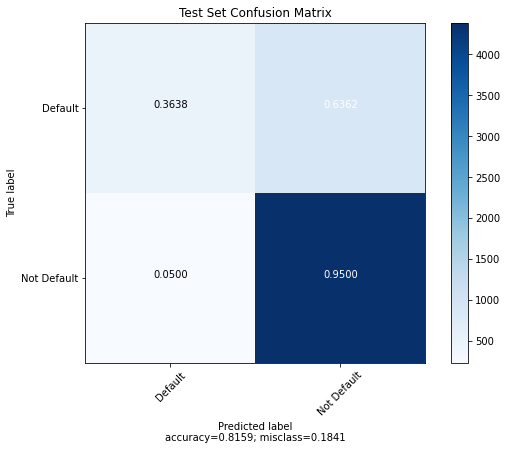

In [ ]:
plot_confusion_matrix(cm=test_confusion, target_names = ['Default', 'Not Default'], title = 'Test Set Confusion Matrix',normalize=True)

In [ ]:
report = classification_report(y_test, Test_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.83      0.95      0.89      4618
     Default       0.68      0.36      0.47      1369

    accuracy                           0.82      5987
   macro avg       0.76      0.66      0.68      5987
weighted avg       0.80      0.82      0.79      5987



### *Dealing with class imbalance*
A big issue with this dataset is that the target variable is imbalanced. In this data set that means there are many more customers who did not default (78%) than customers who did default (22%). Thinking about this in a simple way, if we applied no machine algorithms for prediction and randomly chose whether a person would default or not, we would chose not default 78% of the time. To correct for this imbalance, I'm going to attempt to over sample the minority class using sklearn's SMOTE function to rebalance the data and improve the models.

In [209]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [ ]:
X_resampled.shape

(46602, 39)

In [ ]:
y_resampled.shape

(46602,)

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.2)

### *Updated Models with minority class oversampled*

#### *Logistic Regression*

Run an initial lr model with random inputs

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', penalty='none', max_iter=500, random_state=42)
lr.fit(X_train, y_train)

print('Train Accuracy Score: %s' % lr.score(X_train, y_train))
print('Test Accuracy Score: %s' % lr.score(X_test, y_test))
print('# of iterations %s' % lr.n_iter_[0])

Train Accuracy Score: 0.6982913548456319
Test Accuracy Score: 0.6958480849694239
# of iterations 49


Create a confusion matrix to compare precision and recall. The target variable is imbalanced.

In [ ]:
predictions = lr.predict(X_test)

confusion = confusion_matrix(y_test, predictions, labels=[1, 0])
print(confusion)

[[2549 2125]
 [ 710 3937]]


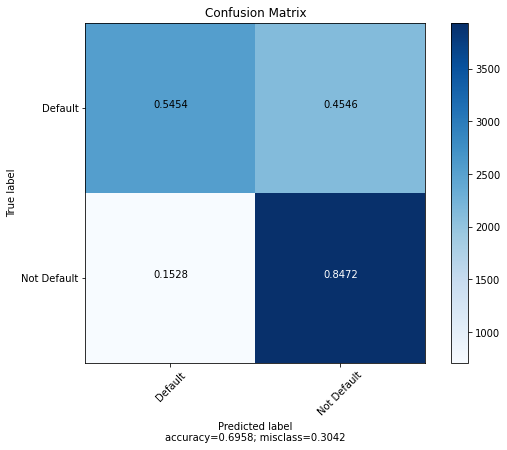

In [ ]:
plot_confusion_matrix(cm=confusion, target_names = ['Default', 'Not Default'], title = 'Confusion Matrix',normalize=True)

In [ ]:
# classification report for initial model
report = classification_report(y_test, predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.65      0.85      0.74      4647
     Default       0.78      0.55      0.64      4674

    accuracy                           0.70      9321
   macro avg       0.72      0.70      0.69      9321
weighted avg       0.72      0.70      0.69      9321



The oversampling of the minority class is definitely improving the model! You can see that recall for default is much higher than the initial models, so its correctly identifying people who default. I'll proceed below to tune the hyperparameters of the remaining models.

Logistic: f1=0.643 auc=0.781


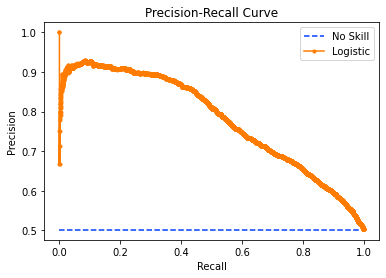

In [ ]:
lr_probs = lr.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, predictions), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

I will try to improve the model using RandomizedSearchCV and GridSearchCV

In [ ]:
lr = LogisticRegression()
# implement randomsearchcv here first
params = [{'C':np.logspace(-10,10,20),
           'penalty': ['l2', 'l1', 'elasticnet', 'none'],
           'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
           'max_iter': np.arange(100,1000,100)}]

rgrid = RandomizedSearchCV(lr,params, cv=3, verbose=True, n_jobs=2)
results = rgrid.fit(X_train, y_train)
results.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   50.1s finished


0.6968160725302432

In [ ]:
results.best_params_

{'C': 1.6237767391887209e-06,
 'max_iter': 200,
 'penalty': 'none',
 'solver': 'lbfgs'}

In [ ]:
lr = LogisticRegression()

params = [{'C': np.logspace(-4,4,20),
          'penalty':['none'],
          'solver': ['lbfgs']}]
clf = GridSearchCV(lr, params, cv=3, verbose=True, n_jobs=2)
results = clf.fit(X_train, y_train)
results.best_score_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   16.0s finished


0.6966819559561171

In [ ]:
results.best_params_

{'C': 0.0001, 'penalty': 'none', 'solver': 'lbfgs'}

Let's input the improved parameters into the new lr model

In [211]:
lr = LogisticRegression(solver='lbfgs', penalty='none', C=0.0001, max_iter=200)
lr.fit(X_train, y_train)

print('Train Accuracy Score: %s' % lr.score(X_train, y_train))
print('Test Accuracy Score: %s' % lr.score(X_test, y_test))
print('# of iterations %s' % lr.n_iter_[0])

Train Accuracy Score: 0.7021539121804673
Test Accuracy Score: 0.6965990773522154
# of iterations 69


In [212]:
Train_predictions = lr.predict(X_train)
Test_predictions = lr.predict(X_test)

train_confusion = confusion_matrix(y_train, Train_predictions, labels=[1,0])
test_confusion = confusion_matrix(y_test, Test_predictions, labels=[1,0])
print(train_confusion)
print(test_confusion)

[[10569  8069]
 [ 3035 15608]]
[[2590 2073]
 [ 755 3903]]


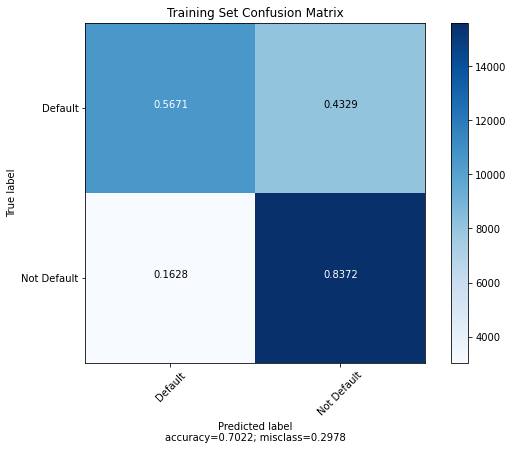

In [213]:
plot_confusion_matrix(cm=train_confusion, target_names = ['Default', 'Not Default'], title = 'Training Set Confusion Matrix',normalize=True)

In [214]:
report = classification_report(y_train, Train_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.66      0.84      0.74     18643
     Default       0.78      0.57      0.66     18638

    accuracy                           0.70     37281
   macro avg       0.72      0.70      0.70     37281
weighted avg       0.72      0.70      0.70     37281



The model still isn't doing a great job correctly identifying people who default (low precision).

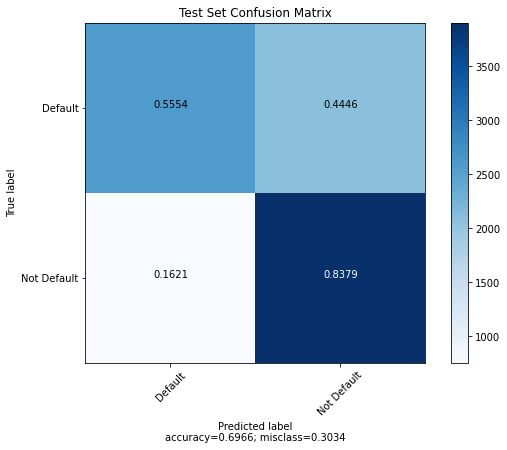

In [215]:
plot_confusion_matrix(cm=test_confusion, target_names = ['Default', 'Not Default'], title = 'Test Set Confusion Matrix',normalize=True)

In [216]:
report = classification_report(y_test, Test_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.65      0.84      0.73      4658
     Default       0.77      0.56      0.65      4663

    accuracy                           0.70      9321
   macro avg       0.71      0.70      0.69      9321
weighted avg       0.71      0.70      0.69      9321



Logistic: f1=0.647 auc=0.774


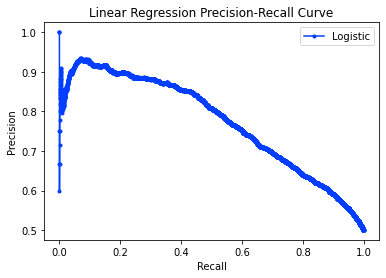

In [219]:
lr_prob = lr.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_prob[:, 1]
# predict class values
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, Test_predictions), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.title('Linear Regression Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Now we'll look at feature importances for the final lr model.

In [220]:
feature_names = [f'feature {i}' for i in range(X.shape[1])]

In [221]:
importance = lr.coef_[0]

In [222]:
lr_import = pd.DataFrame(data=importance, index=feature_names)
lr_import

,0
feature 0,-0.02
feature 1,-0.27
feature 2,0.35
feature 3,-0.12
feature 4,-0.03
feature 5,-0.22
feature 6,0.04
feature 7,0.11
feature 8,0.10
feature 9,-0.12


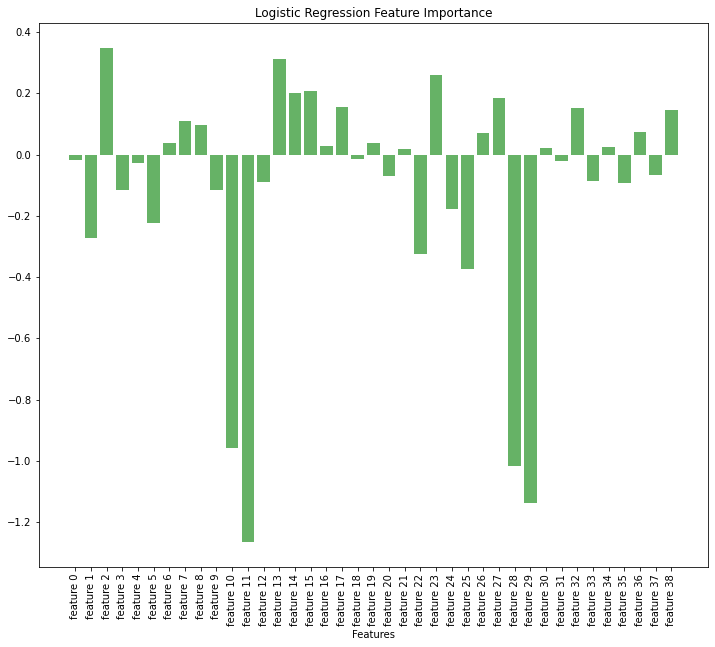

In [223]:
plt.figure(figsize=(12,10))
plt.bar(x=lr_import.index, height=lr_import[0], color='g', alpha=0.6)
plt.xticks(rotation=90)
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Features')
plt.show()

Let's try Ridge Classifier before moving to KNN

In [ ]:
ridge = RidgeClassifierCV(alphas=list(np.logspace(1e-10, 10, 40)), cv=5).fit(X_train,y_train)
print('Training set score: {}'.format(ridge.score(X_train, y_train)))
print('Test set score: {}'.format(ridge.score(X_test, y_test)))

Training set score: 0.6961991362892627
Test set score: 0.6937023924471624


In [ ]:
Train_predictions = ridge.predict(X_train)
Test_predictions = ridge.predict(X_test)

train_confusion = confusion_matrix(y_train, Train_predictions, labels=[1,0])
test_confusion = confusion_matrix(y_test, Test_predictions, labels=[1,0])
print(train_confusion)
print(test_confusion)

[[ 9773  8854]
 [ 2472 16182]]
[[2437 2237]
 [ 618 4029]]


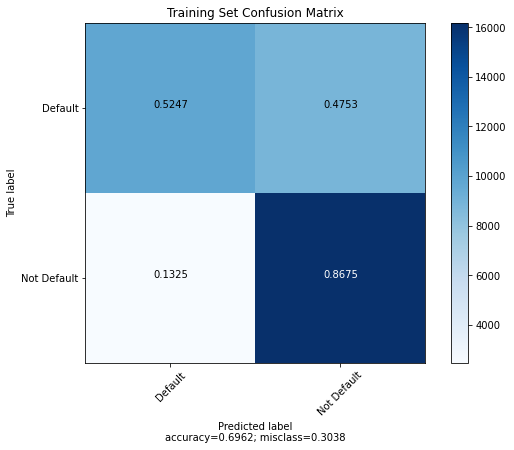

In [ ]:
plot_confusion_matrix(cm=train_confusion, target_names = ['Default', 'Not Default'], title = 'Training Set Confusion Matrix',normalize=True)

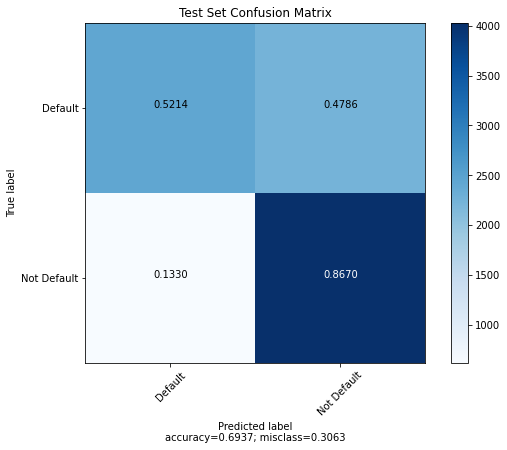

In [ ]:
plot_confusion_matrix(cm=test_confusion, target_names = ['Default', 'Not Default'], title = 'Test Set Confusion Matrix',normalize=True)

#### *KNN Classifiers*

In [ ]:
# initial model for KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 45)
knn.fit(X_train,y_train)

print('training score: {:.3f}'.format(knn.score(X_train, y_train)))
print('test score: {:.3f}'.format(knn.score(X_test, y_test)))

training score: 0.736
test score: 0.725


In [ ]:
Train_predictions = knn.predict(X_train)
Test_predictions = knn.predict(X_test)

train_confusion = confusion_matrix(y_train, Train_predictions, labels=[1,0])
test_confusion = confusion_matrix(y_test, Test_predictions, labels=[1,0])
print(train_confusion)
print(test_confusion)

[[14256  4371]
 [ 5457 13197]]
[[3477 1197]
 [1369 3278]]


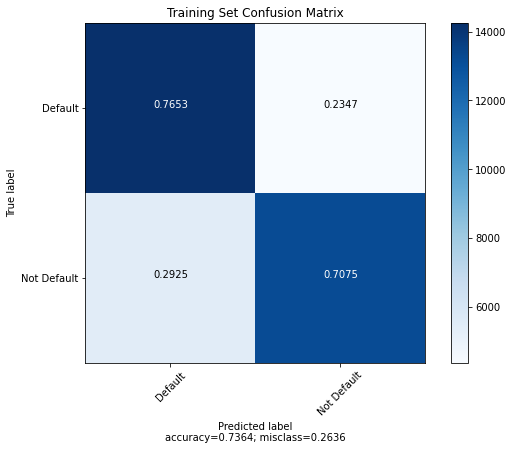

In [ ]:
plot_confusion_matrix(cm=train_confusion, target_names = ['Default', 'Not Default'], title = 'Training Set Confusion Matrix',normalize=True)

In [ ]:
report = classification_report(y_train, Train_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.75      0.71      0.73     18654
     Default       0.72      0.77      0.74     18627

    accuracy                           0.74     37281
   macro avg       0.74      0.74      0.74     37281
weighted avg       0.74      0.74      0.74     37281



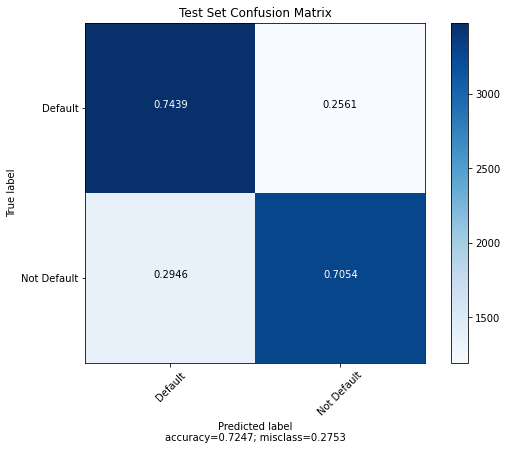

In [ ]:
plot_confusion_matrix(cm=test_confusion, target_names = ['Default', 'Not Default'], title = 'Test Set Confusion Matrix',normalize=True)

In [ ]:
report = classification_report(y_test, Test_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.73      0.71      0.72      4647
     Default       0.72      0.74      0.73      4674

    accuracy                           0.72      9321
   macro avg       0.73      0.72      0.72      9321
weighted avg       0.72      0.72      0.72      9321



I'll try to tune the model to improve the precision and recall scores. First, lets try kinding a value for neighbors.

In [ ]:
k_range=range(2,20)
scores=[]

for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred=knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

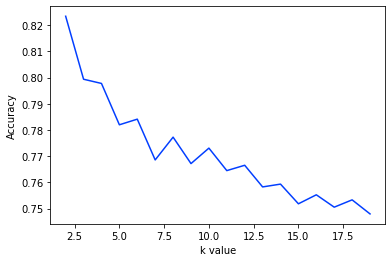

In [ ]:
plt.plot(k_range, scores)
plt.xlabel('k value')
plt.ylabel('Accuracy')

plt.show()

Accuracy really starts to decrease when n_neighbors is greater than 5. I'll put a range of values from 1 to 10 into RandomSearchCV are run to improve hyperparameters.

In [ ]:
# randomized search first
knn = KNeighborsClassifier()
# implement randomsearchcv here first

n_list = list(np.arange(2,10,2).astype(int))
leaf_list = list(np.arange(2,102,20).astype(int))
algo = ['auto', 'ball_tree', 'kd_tree', 'brute']

params = [{'n_neighbors': n_list, 'weights':['uniform', 'distance'],'leaf_size': leaf_list, 'algorithm': algo}]

rgrid = RandomizedSearchCV(knn,params, cv=3, verbose=True, n_jobs=2)
results = rgrid.fit(X_train, y_train)
results.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 10.6min finished


0.8168772296880449

In [ ]:
results.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 82,
 'n_neighbors': 2,
 'weights': 'distance'}

In [ ]:
# use the results from randomized search to narrow values for n and leaf size
knn = KNeighborsClassifier()

n_list = list(np.arange(2,5,1).astype(int))
leaf_list = list(np.arange(80,85,1).astype(int))

params = [{'n_neighbors': n_list,'leaf_size': leaf_list, 'weights': ['distance'], 'algorithm':['ball_tree']}]
clf = GridSearchCV(knn, params, cv=3, verbose=True, n_jobs=2)
results = clf.fit(X_train, y_train)
results.best_score_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed: 35.5min finished


0.8168772296880449

In [75]:
results.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 80,
 'n_neighbors': 2,
 'weights': 'distance'}

In [224]:
knn = KNeighborsClassifier(n_neighbors = 2, leaf_size=80, weights='distance', algorithm='ball_tree')
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=80, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='distance')

In [225]:
Train_predictions = knn.predict(X_train)
Test_predictions = knn.predict(X_test)

train_confusion = confusion_matrix(y_train, Train_predictions, labels=[1,0])
test_confusion = confusion_matrix(y_test, Test_predictions, labels=[1,0])
print(train_confusion)
print(test_confusion)

[[18626    12]
 [    0 18643]]
[[4379  284]
 [1134 3524]]


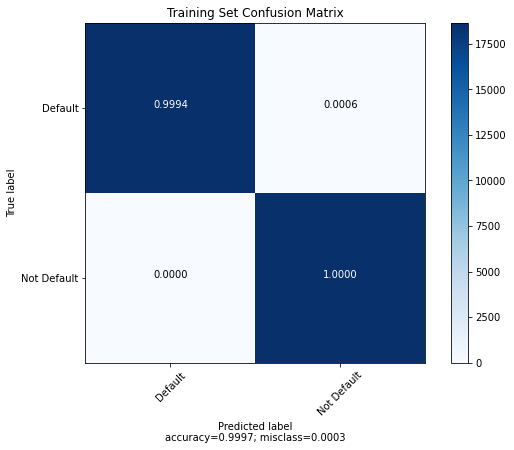

In [226]:
plot_confusion_matrix(cm=train_confusion, target_names = ['Default', 'Not Default'], title = 'Training Set Confusion Matrix',normalize=True)

In [227]:
report = classification_report(y_train, Train_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       1.00      1.00      1.00     18643
     Default       1.00      1.00      1.00     18638

    accuracy                           1.00     37281
   macro avg       1.00      1.00      1.00     37281
weighted avg       1.00      1.00      1.00     37281



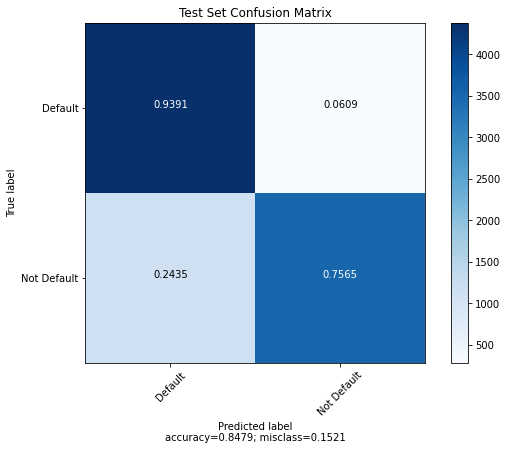

In [228]:
plot_confusion_matrix(cm=test_confusion, target_names = ['Default', 'Not Default'], title = 'Test Set Confusion Matrix',normalize=True)

In [229]:
report = classification_report(y_test, Test_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.93      0.76      0.83      4658
     Default       0.79      0.94      0.86      4663

    accuracy                           0.85      9321
   macro avg       0.86      0.85      0.85      9321
weighted avg       0.86      0.85      0.85      9321



This model is still overfitting on the training set, but it is correctly identifying 93% of people who default in the test set. I'm most interested in correctly identifying people who default, as this is likely the most important metric for a credit company to understand. If they can figure out which customers will default, they can either deny them credit or intervien before their balance increases.

KNN: f1=0.861 auc=0.888


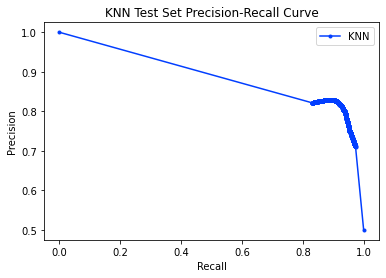

In [230]:
knn_prob = knn.predict_proba(X_test)
# keep probabilities for the positive outcome only
knn_probs = knn_prob[:, 1]
# predict class values
knn_precision, knn_recall, _ = precision_recall_curve(y_test, knn_probs)
knn_f1, knn_auc = f1_score(y_test, Test_predictions), auc(knn_recall, knn_precision)
# summarize scores
print('KNN: f1=%.3f auc=%.3f' % (knn_f1, knn_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(knn_recall, knn_precision, marker='.', label='KNN')
# axis labels
plt.title('KNN Test Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

#### *Random Forests*

In [85]:
from sklearn.ensemble import RandomForestClassifier
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)

print('Training score: %s' % np.mean(cross_val_score(rfc, X_train, y_train, cv=10)))
print('Test score: %s' % np.mean(cross_val_score(rfc, X_test, y_test, cv=10)))

Training score: 0.8494412486749834
Test score: 0.7705177124877524


In [86]:
Train_predictions = rfc.predict(X_train)
Test_predictions = rfc.predict(X_test)

train_confusion = confusion_matrix(y_train, Train_predictions, labels=[1,0])
test_confusion = confusion_matrix(y_test, Test_predictions, labels=[1,0])
print(train_confusion)
print(test_confusion)

[[18691     3]
 [    9 18578]]
[[3937  670]
 [ 663 4051]]


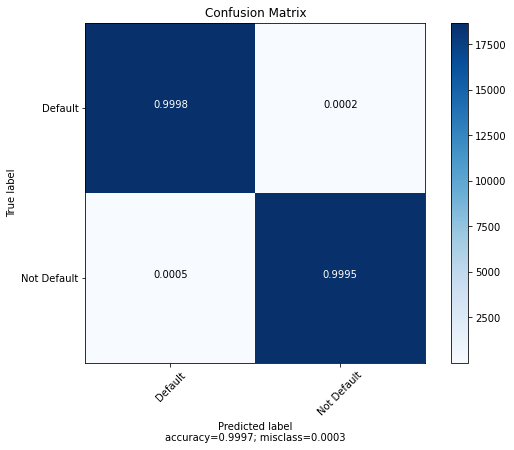

In [87]:
plot_confusion_matrix(cm=train_confusion, target_names = ['Default', 'Not Default'], title = 'Confusion Matrix',normalize=True)

In [88]:
report = classification_report(y_train, Train_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       1.00      1.00      1.00     18587
     Default       1.00      1.00      1.00     18694

    accuracy                           1.00     37281
   macro avg       1.00      1.00      1.00     37281
weighted avg       1.00      1.00      1.00     37281



Woah. That looks like an overfit. Let's look at the test set.

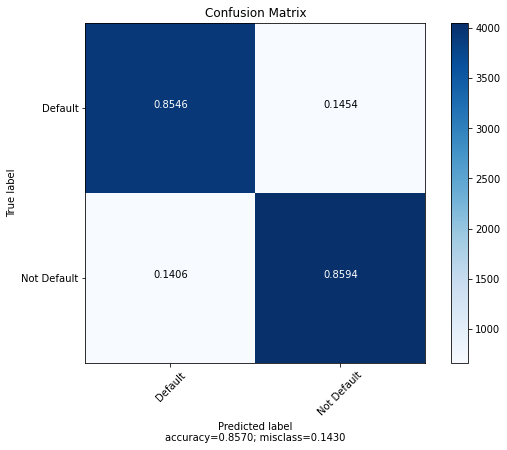

In [89]:
plot_confusion_matrix(cm=test_confusion, target_names = ['Default', 'Not Default'], title = 'Confusion Matrix',normalize=True)

In [90]:
report = classification_report(y_test, Test_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.86      0.86      0.86      4714
     Default       0.86      0.85      0.86      4607

    accuracy                           0.86      9321
   macro avg       0.86      0.86      0.86      9321
weighted avg       0.86      0.86      0.86      9321



This is the best test set i've seen. The model is correctly identifying 85% of people who default and 86% of people who do not default. I'll use RandomizedSearch and Grid Search to see if I can reduce the overfitting and improve the overall score.

In [93]:
# randomized search first
rfc = RandomForestClassifier(random_state=42)
# implement randomsearchcv here first

n_estimators = [int(x) for x in np.linspace(start = 100 , stop = 200, num = 10)] # returns 10 numbers

params = {'max_depth': [2,3,4,5], 'max_features':['auto', 'sqrt', 'log2'], 'n_estimators':n_estimators}

rgrid = RandomizedSearchCV(rfc,params, cv=3, verbose=True, n_jobs=2)
results = rgrid.fit(X_train, y_train)
results.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  2.9min finished


0.7012150961615836

In [94]:
results.best_params_

{'max_depth': 4, 'max_features': 'log2', 'n_estimators': 111}

In [95]:
# this takes a long time to run
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(random_state=42)

params = {'n_estimators': [110,111,112,113],
          'max_features': ['log2'],
          'max_depth':[4,5]}
cv_rfc = GridSearchCV(rfc, params, cv=3, n_jobs=2, verbose=True)
cv_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [96]:
cv_rfc.best_score_

0.7073844585713903

In [97]:
cv_rfc.best_params_

{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 110}

In [232]:
rfc = RandomForestClassifier(max_depth=5, max_features='log2', n_estimators=110)
rfc.fit(X_train, y_train)
print('training score: {:.3f}'.format(rfc.score(X_train, y_train)))
print('test score: {:.3f}'.format(rfc.score(X_test, y_test)))

training score: 0.713
test score: 0.707


In [233]:
Train_predictions = rfc.predict(X_train)
Test_predictions = rfc.predict(X_test)

train_confusion = confusion_matrix(y_train, Train_predictions, labels=[1,0])
test_confusion = confusion_matrix(y_test, Test_predictions, labels=[1,0])
print(train_confusion)
print(test_confusion)

[[10699  7939]
 [ 2772 15871]]
[[2649 2014]
 [ 721 3937]]


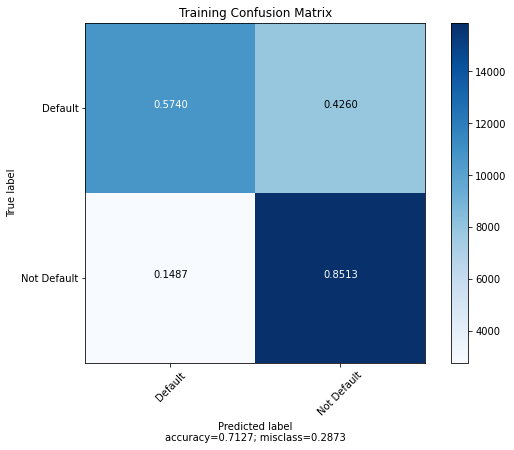

In [234]:
plot_confusion_matrix(cm=train_confusion, target_names = ['Default', 'Not Default'], title = 'Training Confusion Matrix',normalize=True)

In [235]:
report = classification_report(y_train, Train_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.67      0.85      0.75     18643
     Default       0.79      0.57      0.67     18638

    accuracy                           0.71     37281
   macro avg       0.73      0.71      0.71     37281
weighted avg       0.73      0.71      0.71     37281



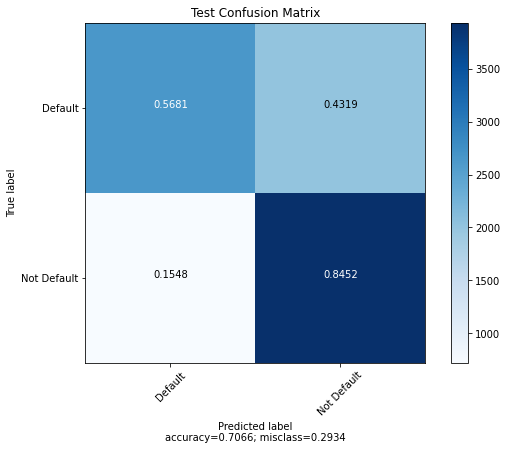

In [236]:
plot_confusion_matrix(cm=test_confusion, target_names = ['Default', 'Not Default'], title = 'Test Confusion Matrix',normalize=True)

In [237]:
report = classification_report(y_test, Test_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.66      0.85      0.74      4658
     Default       0.79      0.57      0.66      4663

    accuracy                           0.71      9321
   macro avg       0.72      0.71      0.70      9321
weighted avg       0.72      0.71      0.70      9321



RFC: f1=0.660 auc=0.786


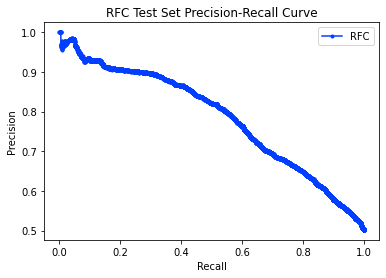

In [238]:
rfc_prob = rfc.predict_proba(X_test)
# keep probabilities for the positive outcome only
rfc_probs = rfc_prob[:, 1]
# predict class values
rfc_precision, rfc_recall, _ = precision_recall_curve(y_test, rfc_probs)
rfc_f1, rfc_auc = f1_score(y_test, Test_predictions), auc(rfc_recall, rfc_precision)
# summarize scores
print('RFC: f1=%.3f auc=%.3f' % (rfc_f1, rfc_auc))
# plot the precision-recall curves
plt.plot(rfc_recall, rfc_precision, marker='.', label='RFC')
# axis labels
plt.title('RFC Test Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [239]:
feature_names = [f'feature {i}' for i in range(X.shape[1])]
importances = rfc.feature_importances_

In [240]:
rfc_import = pd.DataFrame(importances, index=feature_names)
rfc_import[0].sort_values(ascending=False).head(5)

feature 12   0.21
feature 2    0.19
feature 3    0.10
feature 1    0.09
feature 22   0.06
Name: 0, dtype: float64

Comparing feature importances for the Random Forest model.

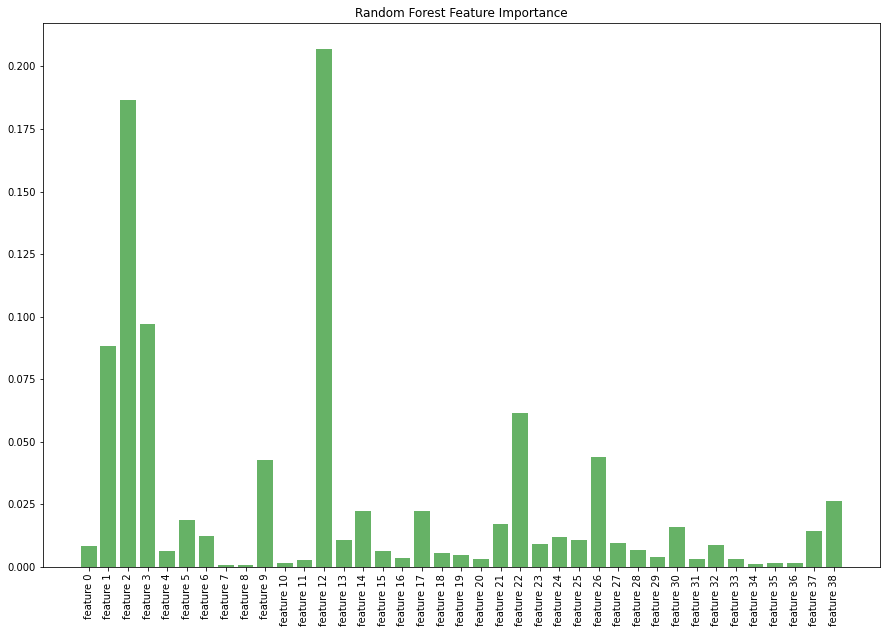

In [241]:
plt.figure(figsize=(15,10))
plt.bar(rfc_import.index, height=rfc_import[0], color='g', alpha=.6)
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=90)
plt.show()

#### *Boosting*

In [108]:
# initialize and fit the model
clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, y_train)

print('training score: {:.3f}'.format(clf.score(X_train, y_train)))
print('test score: {:.3f}'.format(clf.score(X_test, y_test)))

training score: 0.732
test score: 0.727


In [114]:
Train_predictions = clf.predict(X_train)
Test_predictions = clf.predict(X_test)

train_confusion = confusion_matrix(y_train, Train_predictions, labels=[1,0])
test_confusion = confusion_matrix(y_test, Test_predictions, labels=[1,0])
print(train_confusion)
print(test_confusion)

[[12136  6558]
 [ 3436 15151]]
[[2942 1665]
 [ 881 3833]]


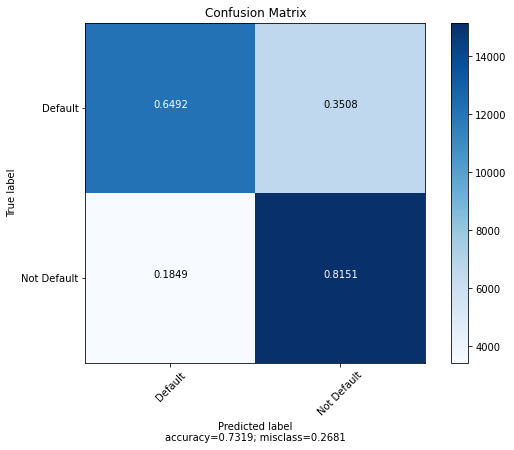

In [115]:
plot_confusion_matrix(cm=train_confusion, target_names = ['Default', 'Not Default'], title = 'Confusion Matrix',normalize=True)

In [111]:
report = classification_report(y_train, Train_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.70      0.82      0.75     18587
     Default       0.78      0.65      0.71     18694

    accuracy                           0.73     37281
   macro avg       0.74      0.73      0.73     37281
weighted avg       0.74      0.73      0.73     37281



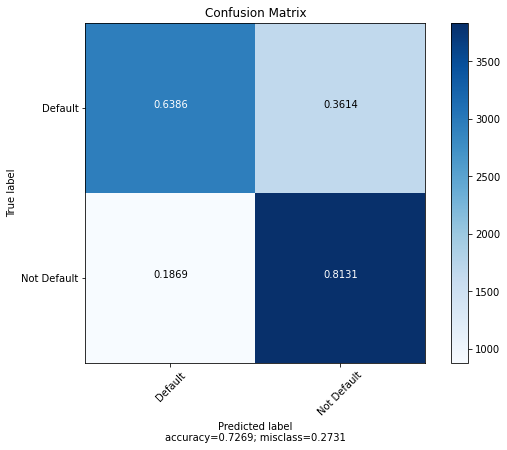

In [112]:
plot_confusion_matrix(cm=test_confusion, target_names = ['Default', 'Not Default'], title = 'Confusion Matrix',normalize=True)

In [113]:
report = classification_report(y_test, Test_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.70      0.81      0.75      4714
     Default       0.77      0.64      0.70      4607

    accuracy                           0.73      9321
   macro avg       0.73      0.73      0.72      9321
weighted avg       0.73      0.73      0.72      9321



In [123]:
# randomized search first
gbc = ensemble.GradientBoostingClassifier(random_state=42)
# implement randomsearchcv here first


params = {'loss':['deviance', 'exponential'], 'n_estimators':[100, 125, 150, 175, 200, 225, 250],'max_depth': [2,3,4,5], 'max_features':['auto', 'sqrt', 'log2', None]}

gsearch = RandomizedSearchCV(gbc,params, cv=3, verbose=True, n_jobs=2)
results = gsearch.fit(X_train, y_train)
results.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 26.3min finished


0.7479413105871623

In [124]:
results.best_params_

{'loss': 'exponential',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 200}

In [134]:
# this takes a long time to run
gbc = ensemble.GradientBoostingClassifier(random_state=42)

params = {'loss': ['exponential'], 'max_depth': [3,4,5], 'max_features':['auto'], 'n_estimators': [190,195,200,205,210]}

cv_gbc = GridSearchCV(gbc, params, cv=3, n_jobs=2, verbose=True)
results = cv_gbc.fit(X_train, y_train)
results.best_params_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed: 65.9min finished


{'loss': 'exponential',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 210}

In [135]:
cv_gbc.best_score_

0.7490678898098228

In [137]:
gbc = ensemble.GradientBoostingClassifier(loss='exponential', max_depth=5, max_features='auto', n_estimators=210)
gbc.fit(X_train, y_train)

print('training score: {:.3f}'.format(gbc.score(X_train, y_train)))
print('test score: {:.3f}'.format(gbc.score(X_test, y_test)))

training score: 0.810
test score: 0.769


In [138]:
Train_predictions = gbc.predict(X_train)
Test_predictions = gbc.predict(X_test)

train_confusion = confusion_matrix(y_train, Train_predictions, labels=[1,0])
test_confusion = confusion_matrix(y_test, Test_predictions, labels=[1,0])
print(train_confusion)
print(test_confusion)

[[14438  4256]
 [ 2810 15777]]
[[3352 1255]
 [ 900 3814]]


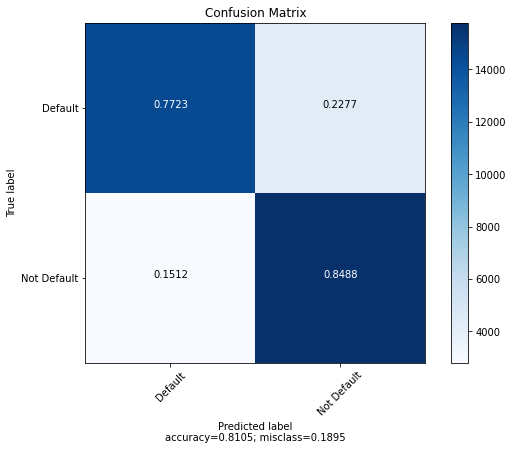

In [139]:
plot_confusion_matrix(cm=train_confusion, target_names = ['Default', 'Not Default'], title = 'Confusion Matrix',normalize=True)

In [140]:
report = classification_report(y_train, Train_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.79      0.85      0.82     18587
     Default       0.84      0.77      0.80     18694

    accuracy                           0.81     37281
   macro avg       0.81      0.81      0.81     37281
weighted avg       0.81      0.81      0.81     37281



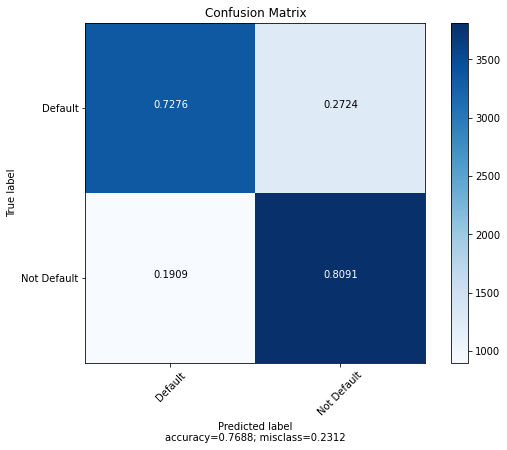

In [141]:
plot_confusion_matrix(cm=test_confusion, target_names = ['Default', 'Not Default'], title = 'Confusion Matrix',normalize=True)

In [142]:
report = classification_report(y_test, Test_predictions, target_names=['Not Default', 'Default'])
print(report)

              precision    recall  f1-score   support

 Not Default       0.75      0.81      0.78      4714
     Default       0.79      0.73      0.76      4607

    accuracy                           0.77      9321
   macro avg       0.77      0.77      0.77      9321
weighted avg       0.77      0.77      0.77      9321



RFC: f1=0.757 auc=0.845


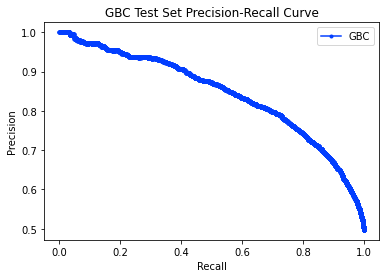

In [143]:
gbc_prob = gbc.predict_proba(X_test)
# keep probabilities for the positive outcome only
gbc_probs = gbc_prob[:, 1]
# predict class values
gbc_precision, gbc_recall, _ = precision_recall_curve(y_test, gbc_probs)
gbc_f1, gbc_auc = f1_score(y_test, Test_predictions), auc(gbc_recall, gbc_precision)
# summarize scores
print('RFC: f1=%.3f auc=%.3f' % (gbc_f1, gbc_auc))
# plot the precision-recall curves
plt.plot(gbc_recall, gbc_precision, marker='.', label='GBC')
# axis labels
plt.title('GBC Test Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

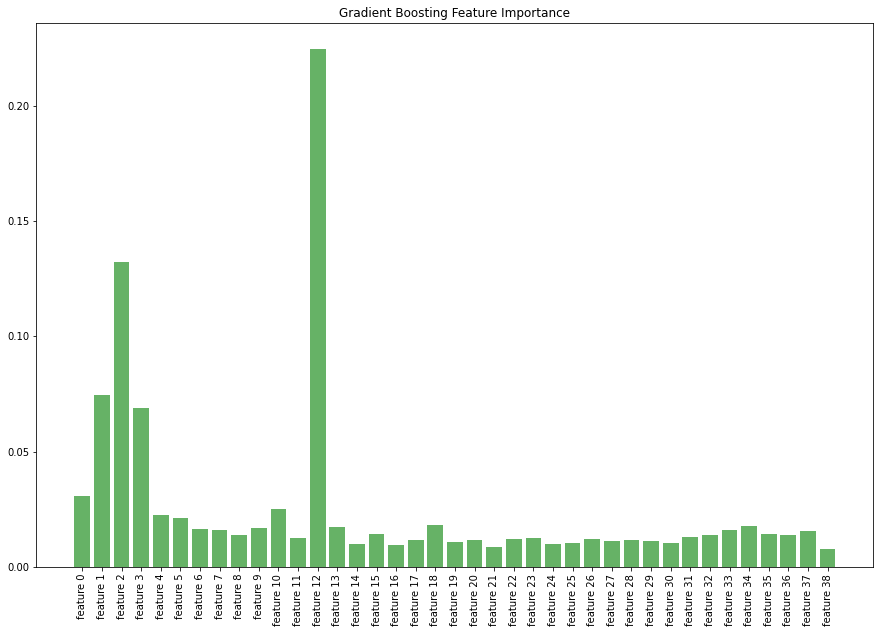

In [144]:
importances = gbc.feature_importances_
rfc_import = pd.DataFrame(importances, index=feature_names)
rfc_import[0].sort_values(ascending=False).head(5)

plt.figure(figsize=(15,10))
plt.bar(rfc_import.index, height=rfc_import[0], color='g', alpha=.6)
plt.title('Gradient Boosting Feature Importance')
plt.xticks(rotation=90)
plt.show()

## Results and Discussion:

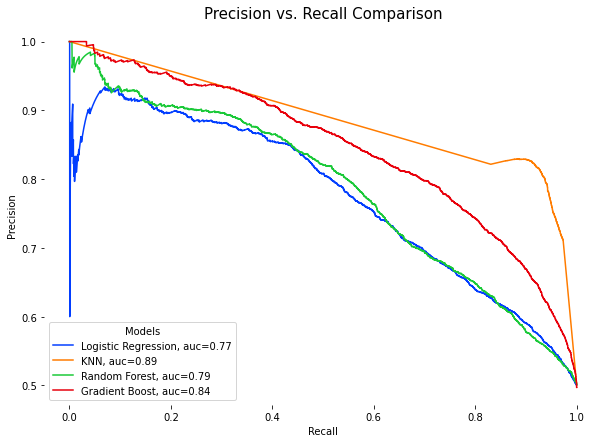

In [244]:
plt.figure(figsize=(10,7))
plt.plot(lr_recall,lr_precision,label="Logistic Regression, auc="+str(round(lr_auc,2)))
plt.plot(knn_recall,knn_precision,label="KNN, auc="+str(round(knn_auc,2)))
plt.plot(rfc_recall,rfc_precision,label="Random Forest, auc="+str(round(rfc_auc,2)))
plt.plot(gbc_recall,gbc_precision,label="Gradient Boost, auc="+str(round(gbc_auc,2)))
plt.legend(loc=3, title='Models', facecolor='white')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall Comparison', size=15)
plt.box(False)

The class imbalance in the target variable had a significant impact on the ability of the model to correctly predict the true positive values (default). It's important to improve the recall of the default class because a credit company or bank is likely more interested in identifying individuals who are going to default on a payment, rather than determining if a person will not default. To improve the model, I over-sampled the minority class to rebalance the data using SMOTE from the imbalance-learn library. This significantly improved the quality of the models and their ability to predict defaults correctly. Looking at the precision-recall comparison above, the best model was surprisingly the KNN Classifier. Although it overfit on the training set, it was able to correctly identify 94% of defaults on the test set. The next best model was Gradient Boost, only predicting 73% of defaults correctly. This is a big drop from KNN, but a significant increase over the models that were not oversampled in version 1.0 of this notebook.

I will continue to investigate why the Random Forest and Gradient boost performed poorer on the over-sampled data than the KNN. 

## Sources: 

**[1] Raw data:** https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

**[2] Literature:** [Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.](https://bradzzz.gitbooks.io/ga-seattle-dsi/content/dsi/dsi_05_classification_databases/2.1-lesson/assets/datasets/DefaultCreditCardClients_yeh_2009.pdf)

**[3] Credit Limits:** https://www.nerdwallet.com/article/finance/30-percent-ideal-credit-utilization-ratio-rule

**[4] Exceeding Credit Limits:** https://www.cnbc.com/select/exceeding-credit-limit/

**[5] Credit Risk:** https://www.investopedia.com/terms/c/creditrisk.asp

**[6] Confusion Matrix Code:** http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

**[7] Kaggle Variable Discussion:** https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608

**[8] Precision-Recall Curve vs. ROC AUC Curve Discussion:** https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

**[9] SMOTE for class imbalance:** https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html